# ADTA 5550 Section(s) 501,790 (Fall 2024 1)
**Final Project - Model Development and Evaluation:** 
Anirudh Boddu – 11754034,
Hasritha Polamarasetti – 11706930,
Raj Kumar Oad – 11747092,
Uttam Kumar Panasala – 11663125
**Exploration and Analysis of Skin Cancer images using Convolutional Neural Networks (CNN), to identify the Melanoma Cancer image.**


In [1]:
# Import necessary libraries
import os
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

/opt/miniconda3/envs/conda3-11/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/miniconda3/envs/conda3-11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/miniconda3/envs/conda3-11/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <EEB3232B-F6A7-3262-948C-BB2F54905803> /opt/miniconda3/envs/conda3-11/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Set the random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

In [3]:
# UKP25
# set output format
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

/var/folders/w1/42sr3rsn6fx44stjsky67c800000gn/T/ipykernel_30458/4107335124.py:5: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [4]:
torch.backends.cudnn.deterministic=True
set_seed(45)

In [5]:
# Define paths for dataset
# Dataset: Skin Cancer Classification Dataset
# https://universe.roboflow.com/smart-healthcare-mnaagement/skin-cancer-classification-kjic2/dataset/7
data_dir = "./data/"  # Update this with the actual path of the dataset
train_dir = os.path.join(data_dir, "Train")
val_dir = os.path.join(data_dir, "Test")

In [6]:
# Define image transformations
transform = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

In [7]:
# Split the dataset into training and validation sets
from torch.utils.data import random_split

train_dataset = datasets.ImageFolder(train_dir, transform=transform['train'])

# Total dataset size
total_size = len(train_dataset)

# Split sizes
train_size = int(0.9 * total_size)  # 80% for training
val_size = total_size - train_size  # Remaining 20% for validation

# Train-validation split
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# DataLoaders for train and validation
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

# Verify splits
print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")

Train size: 2015
Validation size: 224


In [15]:
# Define optimizer, loss, and device
criterion = nn.CrossEntropyLoss()
device = 'mps' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

'mps'

In [16]:
# Define a function to train the model
import time
from tqdm import tqdm
import torch
import pandas as pd

def train_network_lrs(model, loss_func, train_loader, val_loader=None, test_loader=None, score_funcs=None,
                  epochs=50, device="cpu", checkpoint_file=None, lr_schedule=None, optimizer=None, disable_tqdm=False):
    """
    Train a neural network with detailed metrics tracking and support for validation, testing, and learning rate scheduling.

    Arguments:
    model -- the PyTorch model to train
    loss_func -- the loss function to optimize
    train_loader -- PyTorch DataLoader for training data
    val_loader -- (optional) DataLoader for validation data
    test_loader -- (optional) DataLoader for test data
    score_funcs -- (optional) Dictionary of scoring functions for evaluation
    epochs -- Number of training epochs
    device -- Device for computation ("cuda" or "cpu")
    checkpoint_file -- (optional) File path to save model checkpoints
    lr_schedule -- (optional) Learning rate scheduler
    optimizer -- (optional) Optimizer for training
    disable_tqdm -- Disable tqdm progress bar (for logging)

    Returns:
    model -- Trained PyTorch model
    results -- A pandas DataFrame containing training, validation, and test metrics over epochs
    """

    if score_funcs is None:
        score_funcs = {}

    # Metrics to track
    to_track = ["epoch", "total_time", "train_loss"]
    if val_loader:
        to_track.extend(["val_loss", "val_accuracy"])
        to_track.extend([f"val_{metric}" for metric in score_funcs])
    if test_loader:
        to_track.extend(["test_loss", "test_accuracy"])
        to_track.extend([f"test_{metric}" for metric in score_funcs])

    results = {metric: [] for metric in to_track}
    total_train_time = 0

    if optimizer is None:
        optimizer = torch.optim.AdamW(model.parameters())  # Default optimizer

    model.to(device)

    # Training loop
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
        epoch_start = time.time()

        # Training phase
        model.train()
        train_loss = 0.0
        correct_train, total_train = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # Record training metrics
        results["epoch"].append(epoch + 1)
        results["train_loss"].append(avg_train_loss)

        # Validation phase
        if val_loader:
            model.eval()
            val_loss, correct_val, total_val = 0.0, 0, 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = loss_func(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())

            avg_val_loss = val_loss / len(val_loader.dataset)
            val_accuracy = 100 * correct_val / total_val
            results["val_loss"].append(avg_val_loss)
            results["val_accuracy"].append(val_accuracy)

            # Compute custom metrics
            for metric_name, metric_func in score_funcs.items():
                results[f"val_{metric_name}"].append(metric_func(y_true, y_pred))

        # Test phase (optional)
        if test_loader:
            model.eval()
            test_loss, correct_test, total_test = 0.0, 0, 0
            y_true, y_pred = [], []
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = loss_func(outputs, labels)
                    test_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs, 1)
                    correct_test += (predicted == labels).sum().item()
                    total_test += labels.size(0)
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(predicted.cpu().numpy())

            avg_test_loss = test_loss / len(test_loader.dataset)
            test_accuracy = 100 * correct_test / total_test
            results["test_loss"].append(avg_test_loss)
            results["test_accuracy"].append(test_accuracy)

            # Compute custom metrics
            for metric_name, metric_func in score_funcs.items():
                results[f"test_{metric_name}"].append(metric_func(y_true, y_pred))

        # Update learning rate
        if lr_schedule:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(avg_val_loss if val_loader else avg_train_loss)
            else:
                lr_schedule.step()

        # Save checkpoint
        if checkpoint_file:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results': results
            }, checkpoint_file)

        epoch_end = time.time()
        total_train_time += epoch_end - epoch_start
        results["total_time"].append(total_train_time)

        # Print epoch summary
        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%" if val_loader else "")

    return model, pd.DataFrame.from_dict(results)

In [17]:
# Train the model with lr schedule
from torchvision.models import ResNet18_Weights

def get_new_model(epochs=10, eta_0 = 0.001, weights=ResNet18_Weights.IMAGENET1K_V1):    
    model = models.resnet18(weights=weights) 
    num_features = model.fc.in_features

    # optimizer18 = optim.Adam(model18.parameters(), lr=eta_0) # 66.52%
    # optimizer18 = optim.AdamW(model18.parameters(), lr=eta_0, weight_decay=1e-4) # 80, 72
    # optimizer18 = torch.optim.SGD(model18.parameters(), lr=eta_0, momentum=0.9, nesterov=True) # 74, 67

    optimizer = optim.SGD(
        model.parameters(), 
        lr=eta_0, 
        momentum=0.9, 
        weight_decay=1e-4, 
        nesterov=True
    )

    model.fc = nn.Linear(num_features, len(train_dataset.classes))  # Adjust output for the number of classes
    model = model.to(device)
    return model, optimizer    

def get_new_model_adam(epochs=10, eta_0 = 0.001, weights=ResNet18_Weights.IMAGENET1K_V1):    
    model = models.resnet18(weights=weights) 
    num_features = model.fc.in_features
    optimizer = optim.AdamW(model.parameters(), lr=eta_0, weight_decay=1e-4)
    model.fc = nn.Linear(num_features, len(train_dataset.classes))  # Adjust output for the number of classes
    model = model.to(device)
    return model, optimizer  

In [11]:
epochs = 50

In [70]:
# SGD - Epoch 50/50, Train Loss: 0.1445, Train Accuracy: 92.66%, Val Loss: 0.9471, Val Accuracy: 69.64%
model18, optimizer18 = get_new_model(epochs=epochs, eta_0 = 0.001)
trained_model18_fc_results, training_history18_fc_results = train_network_lrs(
    model=model18,
    loss_func=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=val_loader,  # Optional test_loader, replace if necessary
    epochs=epochs,  # Update based on your needs
    optimizer=optimizer18,
    score_funcs={'Accuracy': accuracy_score},  # Add additional metrics if needed
    device=device
)

Epoch:   2%|▏         | 1/50 [00:48<39:12, 48.02s/it]

Epoch 1/50, Train Loss: 2.0923, Train Accuracy: 21.64%, Val Loss: 1.6755, Val Accuracy: 39.73%


Epoch:   4%|▍         | 2/50 [01:31<36:29, 45.62s/it]

Epoch 2/50, Train Loss: 1.3942, Train Accuracy: 55.78%, Val Loss: 1.2643, Val Accuracy: 58.93%


Epoch:   6%|▌         | 3/50 [02:17<35:35, 45.43s/it]

Epoch 3/50, Train Loss: 1.1090, Train Accuracy: 65.96%, Val Loss: 1.1000, Val Accuracy: 66.52%


Epoch:   8%|▊         | 4/50 [03:01<34:26, 44.93s/it]

Epoch 4/50, Train Loss: 0.9511, Train Accuracy: 70.52%, Val Loss: 1.0683, Val Accuracy: 67.41%


Epoch:  10%|█         | 5/50 [03:47<34:01, 45.37s/it]

Epoch 5/50, Train Loss: 0.8427, Train Accuracy: 73.65%, Val Loss: 0.8739, Val Accuracy: 73.66%


Epoch:  12%|█▏        | 6/50 [04:31<32:54, 44.87s/it]

Epoch 6/50, Train Loss: 0.7766, Train Accuracy: 74.39%, Val Loss: 0.9121, Val Accuracy: 72.32%


Epoch:  14%|█▍        | 7/50 [05:15<31:52, 44.49s/it]

Epoch 7/50, Train Loss: 0.6990, Train Accuracy: 77.67%, Val Loss: 0.8339, Val Accuracy: 71.88%


Epoch:  16%|█▌        | 8/50 [05:59<31:09, 44.52s/it]

Epoch 8/50, Train Loss: 0.6545, Train Accuracy: 78.16%, Val Loss: 0.9705, Val Accuracy: 68.30%


Epoch:  18%|█▊        | 9/50 [06:46<30:59, 45.35s/it]

Epoch 9/50, Train Loss: 0.6003, Train Accuracy: 79.75%, Val Loss: 0.7893, Val Accuracy: 72.77%


Epoch:  20%|██        | 10/50 [07:30<29:54, 44.85s/it]

Epoch 10/50, Train Loss: 0.5281, Train Accuracy: 82.58%, Val Loss: 0.8091, Val Accuracy: 72.32%


Epoch:  22%|██▏       | 11/50 [08:14<29:00, 44.63s/it]

Epoch 11/50, Train Loss: 0.5113, Train Accuracy: 83.03%, Val Loss: 0.7635, Val Accuracy: 71.43%


Epoch:  24%|██▍       | 12/50 [08:58<28:11, 44.50s/it]

Epoch 12/50, Train Loss: 0.4727, Train Accuracy: 84.62%, Val Loss: 0.7804, Val Accuracy: 73.66%


Epoch:  26%|██▌       | 13/50 [09:44<27:35, 44.75s/it]

Epoch 13/50, Train Loss: 0.4577, Train Accuracy: 84.62%, Val Loss: 0.8418, Val Accuracy: 73.21%


Epoch:  28%|██▊       | 14/50 [10:28<26:45, 44.60s/it]

Epoch 14/50, Train Loss: 0.4096, Train Accuracy: 86.50%, Val Loss: 0.8844, Val Accuracy: 67.86%


Epoch:  30%|███       | 15/50 [11:14<26:19, 45.14s/it]

Epoch 15/50, Train Loss: 0.3967, Train Accuracy: 87.15%, Val Loss: 0.7726, Val Accuracy: 75.89%


Epoch:  32%|███▏      | 16/50 [12:00<25:38, 45.24s/it]

Epoch 16/50, Train Loss: 0.3700, Train Accuracy: 87.64%, Val Loss: 0.7814, Val Accuracy: 75.00%


Epoch:  34%|███▍      | 17/50 [12:45<24:50, 45.17s/it]

Epoch 17/50, Train Loss: 0.3546, Train Accuracy: 87.54%, Val Loss: 0.7471, Val Accuracy: 74.55%


Epoch:  36%|███▌      | 18/50 [13:29<23:52, 44.78s/it]

Epoch 18/50, Train Loss: 0.3375, Train Accuracy: 89.08%, Val Loss: 0.8324, Val Accuracy: 70.98%


Epoch:  38%|███▊      | 19/50 [14:14<23:09, 44.81s/it]

Epoch 19/50, Train Loss: 0.3135, Train Accuracy: 88.93%, Val Loss: 0.7732, Val Accuracy: 71.43%


Epoch:  40%|████      | 20/50 [14:59<22:32, 45.08s/it]

Epoch 20/50, Train Loss: 0.3025, Train Accuracy: 89.68%, Val Loss: 0.8518, Val Accuracy: 70.98%


Epoch:  42%|████▏     | 21/50 [15:45<21:51, 45.23s/it]

Epoch 21/50, Train Loss: 0.2659, Train Accuracy: 90.52%, Val Loss: 0.8044, Val Accuracy: 72.77%


Epoch:  44%|████▍     | 22/50 [16:30<21:01, 45.04s/it]

Epoch 22/50, Train Loss: 0.2748, Train Accuracy: 90.22%, Val Loss: 0.8252, Val Accuracy: 73.21%


Epoch:  46%|████▌     | 23/50 [17:16<20:26, 45.43s/it]

Epoch 23/50, Train Loss: 0.2455, Train Accuracy: 91.51%, Val Loss: 0.8084, Val Accuracy: 72.77%


Epoch:  48%|████▊     | 24/50 [18:01<19:41, 45.46s/it]

Epoch 24/50, Train Loss: 0.2452, Train Accuracy: 91.32%, Val Loss: 0.8024, Val Accuracy: 72.32%


Epoch:  50%|█████     | 25/50 [18:47<18:59, 45.59s/it]

Epoch 25/50, Train Loss: 0.2342, Train Accuracy: 91.91%, Val Loss: 0.8387, Val Accuracy: 72.32%


Epoch:  52%|█████▏    | 26/50 [19:35<18:29, 46.22s/it]

Epoch 26/50, Train Loss: 0.2287, Train Accuracy: 91.76%, Val Loss: 0.7921, Val Accuracy: 74.55%


Epoch:  54%|█████▍    | 27/50 [20:20<17:34, 45.83s/it]

Epoch 27/50, Train Loss: 0.2245, Train Accuracy: 92.16%, Val Loss: 0.8360, Val Accuracy: 71.88%


Epoch:  56%|█████▌    | 28/50 [21:09<17:08, 46.73s/it]

Epoch 28/50, Train Loss: 0.2148, Train Accuracy: 91.76%, Val Loss: 0.8410, Val Accuracy: 73.21%


Epoch:  58%|█████▊    | 29/50 [21:54<16:11, 46.27s/it]

Epoch 29/50, Train Loss: 0.2172, Train Accuracy: 91.91%, Val Loss: 0.9081, Val Accuracy: 69.20%


Epoch:  60%|██████    | 30/50 [22:39<15:20, 46.01s/it]

Epoch 30/50, Train Loss: 0.1957, Train Accuracy: 92.21%, Val Loss: 0.8388, Val Accuracy: 72.77%


Epoch:  62%|██████▏   | 31/50 [23:28<14:47, 46.71s/it]

Epoch 31/50, Train Loss: 0.1904, Train Accuracy: 92.56%, Val Loss: 0.8210, Val Accuracy: 74.55%


Epoch:  64%|██████▍   | 32/50 [24:12<13:48, 46.03s/it]

Epoch 32/50, Train Loss: 0.1914, Train Accuracy: 92.66%, Val Loss: 0.8569, Val Accuracy: 72.32%


Epoch:  66%|██████▌   | 33/50 [25:01<13:19, 47.02s/it]

Epoch 33/50, Train Loss: 0.1885, Train Accuracy: 92.16%, Val Loss: 0.8242, Val Accuracy: 73.21%


Epoch:  68%|██████▊   | 34/50 [25:49<12:37, 47.34s/it]

Epoch 34/50, Train Loss: 0.1876, Train Accuracy: 91.91%, Val Loss: 0.8498, Val Accuracy: 73.66%


Epoch:  70%|███████   | 35/50 [26:37<11:51, 47.43s/it]

Epoch 35/50, Train Loss: 0.1895, Train Accuracy: 91.86%, Val Loss: 0.9726, Val Accuracy: 70.09%


Epoch:  72%|███████▏  | 36/50 [27:28<11:17, 48.41s/it]

Epoch 36/50, Train Loss: 0.1686, Train Accuracy: 93.10%, Val Loss: 0.9293, Val Accuracy: 71.43%


Epoch:  74%|███████▍  | 37/50 [28:12<10:11, 47.01s/it]

Epoch 37/50, Train Loss: 0.1713, Train Accuracy: 92.95%, Val Loss: 0.8827, Val Accuracy: 73.66%


Epoch:  76%|███████▌  | 38/50 [28:59<09:24, 47.06s/it]

Epoch 38/50, Train Loss: 0.1717, Train Accuracy: 92.95%, Val Loss: 0.9659, Val Accuracy: 71.88%


Epoch:  78%|███████▊  | 39/50 [29:43<08:28, 46.25s/it]

Epoch 39/50, Train Loss: 0.1664, Train Accuracy: 92.80%, Val Loss: 0.9062, Val Accuracy: 73.21%


Epoch:  80%|████████  | 40/50 [30:34<07:55, 47.53s/it]

Epoch 40/50, Train Loss: 0.1536, Train Accuracy: 93.70%, Val Loss: 0.8853, Val Accuracy: 72.77%


Epoch:  82%|████████▏ | 41/50 [31:21<07:06, 47.44s/it]

Epoch 41/50, Train Loss: 0.1559, Train Accuracy: 93.50%, Val Loss: 0.8414, Val Accuracy: 72.77%


Epoch:  84%|████████▍ | 42/50 [32:05<06:11, 46.38s/it]

Epoch 42/50, Train Loss: 0.1485, Train Accuracy: 93.20%, Val Loss: 0.8883, Val Accuracy: 73.21%


Epoch:  86%|████████▌ | 43/50 [32:52<05:26, 46.62s/it]

Epoch 43/50, Train Loss: 0.1613, Train Accuracy: 93.30%, Val Loss: 0.9638, Val Accuracy: 69.20%


Epoch:  88%|████████▊ | 44/50 [33:38<04:38, 46.48s/it]

Epoch 44/50, Train Loss: 0.1557, Train Accuracy: 93.45%, Val Loss: 0.9378, Val Accuracy: 71.43%


Epoch:  90%|█████████ | 45/50 [34:22<03:48, 45.74s/it]

Epoch 45/50, Train Loss: 0.1415, Train Accuracy: 93.55%, Val Loss: 0.8894, Val Accuracy: 73.21%


Epoch:  92%|█████████▏| 46/50 [35:06<03:00, 45.21s/it]

Epoch 46/50, Train Loss: 0.1403, Train Accuracy: 93.40%, Val Loss: 0.9626, Val Accuracy: 70.09%


Epoch:  94%|█████████▍| 47/50 [35:50<02:14, 44.94s/it]

Epoch 47/50, Train Loss: 0.1486, Train Accuracy: 93.25%, Val Loss: 0.8973, Val Accuracy: 72.77%


Epoch:  96%|█████████▌| 48/50 [36:34<01:29, 44.66s/it]

Epoch 48/50, Train Loss: 0.1444, Train Accuracy: 93.00%, Val Loss: 0.9653, Val Accuracy: 72.32%


Epoch:  98%|█████████▊| 49/50 [37:18<00:44, 44.44s/it]

Epoch 49/50, Train Loss: 0.1398, Train Accuracy: 93.20%, Val Loss: 0.9705, Val Accuracy: 71.43%


Epoch: 100%|██████████| 50/50 [38:03<00:00, 45.67s/it]

Epoch 50/50, Train Loss: 0.1476, Train Accuracy: 92.46%, Val Loss: 0.9058, Val Accuracy: 70.09%


In [74]:
# SGD +Exponential Decay - Epoch 50/50, Train Loss: 0.2500, Train Accuracy: 90.97%, Val Loss: 0.6717, Val Accuracy: 73.66%
model18, optimizer18 = get_new_model(epochs=epochs, eta_0 = 0.001)

eta_min = 0.0001 #Our desired final learning rate $\eta_{\mathit{min}}$
eta_0 = 0.001
gamma_expo = (eta_min/eta_0)**(1/epochs) #compute $\gamma$ that results in $\eta_{\mathit{min}}$

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer18, gamma_expo)

trained_model18_fc_results_expolr, training_history18_fc_results_expolr = train_network_lrs(
    model=model18,
    loss_func=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=val_loader,  
    epochs=epochs,
    optimizer=optimizer18,
    lr_schedule=scheduler,
    score_funcs={'Accuracy': accuracy_score},  # Add additional metrics if needed
    device=device
)

Epoch:   2%|▏         | 1/50 [00:45<37:29, 45.90s/it]

Epoch 1/50, Train Loss: 1.8752, Train Accuracy: 33.45%, Val Loss: 1.5496, Val Accuracy: 46.43%


Epoch:   4%|▍         | 2/50 [01:30<36:03, 45.07s/it]

Epoch 2/50, Train Loss: 1.3648, Train Accuracy: 57.67%, Val Loss: 1.1604, Val Accuracy: 61.61%


Epoch:   6%|▌         | 3/50 [02:15<35:13, 44.98s/it]

Epoch 3/50, Train Loss: 1.1168, Train Accuracy: 64.47%, Val Loss: 1.0318, Val Accuracy: 67.41%


Epoch:   8%|▊         | 4/50 [02:59<34:23, 44.86s/it]

Epoch 4/50, Train Loss: 0.9560, Train Accuracy: 70.47%, Val Loss: 0.9276, Val Accuracy: 70.98%


Epoch:  10%|█         | 5/50 [03:44<33:36, 44.82s/it]

Epoch 5/50, Train Loss: 0.8578, Train Accuracy: 73.90%, Val Loss: 0.9158, Val Accuracy: 69.20%


Epoch:  12%|█▏        | 6/50 [04:29<32:49, 44.75s/it]

Epoch 6/50, Train Loss: 0.7864, Train Accuracy: 74.69%, Val Loss: 0.8667, Val Accuracy: 70.54%


Epoch:  14%|█▍        | 7/50 [05:13<32:01, 44.68s/it]

Epoch 7/50, Train Loss: 0.7179, Train Accuracy: 76.48%, Val Loss: 0.8636, Val Accuracy: 68.75%


Epoch:  16%|█▌        | 8/50 [05:59<31:35, 45.13s/it]

Epoch 8/50, Train Loss: 0.6774, Train Accuracy: 77.87%, Val Loss: 0.8274, Val Accuracy: 71.43%


Epoch:  18%|█▊        | 9/50 [06:44<30:47, 45.05s/it]

Epoch 9/50, Train Loss: 0.6165, Train Accuracy: 80.05%, Val Loss: 0.7784, Val Accuracy: 72.32%


Epoch:  20%|██        | 10/50 [07:29<30:00, 45.01s/it]

Epoch 10/50, Train Loss: 0.5951, Train Accuracy: 79.90%, Val Loss: 0.7866, Val Accuracy: 70.98%


Epoch:  22%|██▏       | 11/50 [08:14<29:08, 44.82s/it]

Epoch 11/50, Train Loss: 0.5631, Train Accuracy: 81.69%, Val Loss: 0.7711, Val Accuracy: 74.55%


Epoch:  24%|██▍       | 12/50 [08:58<28:22, 44.81s/it]

Epoch 12/50, Train Loss: 0.5374, Train Accuracy: 82.43%, Val Loss: 0.7415, Val Accuracy: 74.55%


Epoch:  26%|██▌       | 13/50 [09:43<27:37, 44.80s/it]

Epoch 13/50, Train Loss: 0.5013, Train Accuracy: 83.57%, Val Loss: 0.7690, Val Accuracy: 72.32%


Epoch:  28%|██▊       | 14/50 [10:28<26:49, 44.70s/it]

Epoch 14/50, Train Loss: 0.4921, Train Accuracy: 83.77%, Val Loss: 0.7788, Val Accuracy: 72.32%


Epoch:  30%|███       | 15/50 [11:12<26:04, 44.69s/it]

Epoch 15/50, Train Loss: 0.4757, Train Accuracy: 83.92%, Val Loss: 0.7689, Val Accuracy: 72.32%


Epoch:  32%|███▏      | 16/50 [11:57<25:20, 44.72s/it]

Epoch 16/50, Train Loss: 0.4506, Train Accuracy: 84.96%, Val Loss: 0.7713, Val Accuracy: 70.98%


Epoch:  34%|███▍      | 17/50 [12:42<24:35, 44.73s/it]

Epoch 17/50, Train Loss: 0.4387, Train Accuracy: 85.41%, Val Loss: 0.7436, Val Accuracy: 73.21%


Epoch:  36%|███▌      | 18/50 [13:26<23:45, 44.56s/it]

Epoch 18/50, Train Loss: 0.4128, Train Accuracy: 86.35%, Val Loss: 0.7798, Val Accuracy: 70.09%


Epoch:  38%|███▊      | 19/50 [14:11<23:02, 44.59s/it]

Epoch 19/50, Train Loss: 0.4145, Train Accuracy: 86.10%, Val Loss: 0.7712, Val Accuracy: 71.43%


Epoch:  40%|████      | 20/50 [14:55<22:17, 44.58s/it]

Epoch 20/50, Train Loss: 0.4025, Train Accuracy: 86.75%, Val Loss: 0.7730, Val Accuracy: 69.20%


Epoch:  42%|████▏     | 21/50 [15:40<21:31, 44.55s/it]

Epoch 21/50, Train Loss: 0.3748, Train Accuracy: 88.14%, Val Loss: 0.7869, Val Accuracy: 74.11%


Epoch:  44%|████▍     | 22/50 [16:24<20:48, 44.58s/it]

Epoch 22/50, Train Loss: 0.3564, Train Accuracy: 88.04%, Val Loss: 0.7517, Val Accuracy: 71.88%


Epoch:  46%|████▌     | 23/50 [17:09<20:04, 44.62s/it]

Epoch 23/50, Train Loss: 0.3594, Train Accuracy: 87.74%, Val Loss: 0.7408, Val Accuracy: 74.11%


Epoch:  48%|████▊     | 24/50 [17:53<19:17, 44.51s/it]

Epoch 24/50, Train Loss: 0.3258, Train Accuracy: 89.33%, Val Loss: 0.7371, Val Accuracy: 71.88%


Epoch:  50%|█████     | 25/50 [18:37<18:29, 44.38s/it]

Epoch 25/50, Train Loss: 0.3384, Train Accuracy: 88.34%, Val Loss: 0.7409, Val Accuracy: 74.55%


Epoch:  52%|█████▏    | 26/50 [19:22<17:46, 44.45s/it]

Epoch 26/50, Train Loss: 0.3297, Train Accuracy: 89.13%, Val Loss: 0.7635, Val Accuracy: 72.32%


Epoch:  54%|█████▍    | 27/50 [20:06<17:01, 44.41s/it]

Epoch 27/50, Train Loss: 0.3220, Train Accuracy: 88.73%, Val Loss: 0.7542, Val Accuracy: 72.77%


Epoch:  56%|█████▌    | 28/50 [20:51<16:17, 44.41s/it]

Epoch 28/50, Train Loss: 0.3149, Train Accuracy: 89.18%, Val Loss: 0.6939, Val Accuracy: 75.89%


Epoch:  58%|█████▊    | 29/50 [21:35<15:33, 44.44s/it]

Epoch 29/50, Train Loss: 0.3123, Train Accuracy: 89.83%, Val Loss: 0.7226, Val Accuracy: 73.66%


Epoch:  60%|██████    | 30/50 [22:20<14:47, 44.40s/it]

Epoch 30/50, Train Loss: 0.2960, Train Accuracy: 89.98%, Val Loss: 0.7463, Val Accuracy: 72.32%


Epoch:  62%|██████▏   | 31/50 [23:04<14:02, 44.35s/it]

Epoch 31/50, Train Loss: 0.2988, Train Accuracy: 89.98%, Val Loss: 0.7729, Val Accuracy: 69.20%


Epoch:  64%|██████▍   | 32/50 [23:48<13:18, 44.34s/it]

Epoch 32/50, Train Loss: 0.2886, Train Accuracy: 90.97%, Val Loss: 0.7269, Val Accuracy: 74.11%


Epoch:  66%|██████▌   | 33/50 [24:32<12:33, 44.30s/it]

Epoch 33/50, Train Loss: 0.2901, Train Accuracy: 90.12%, Val Loss: 0.7489, Val Accuracy: 73.21%


Epoch:  68%|██████▊   | 34/50 [25:17<11:49, 44.34s/it]

Epoch 34/50, Train Loss: 0.2754, Train Accuracy: 91.02%, Val Loss: 0.7533, Val Accuracy: 72.77%


Epoch:  70%|███████   | 35/50 [26:01<11:05, 44.37s/it]

Epoch 35/50, Train Loss: 0.2766, Train Accuracy: 90.62%, Val Loss: 0.7684, Val Accuracy: 74.55%


Epoch:  72%|███████▏  | 36/50 [26:46<10:23, 44.52s/it]

Epoch 36/50, Train Loss: 0.2832, Train Accuracy: 90.42%, Val Loss: 0.7930, Val Accuracy: 71.88%


Epoch:  74%|███████▍  | 37/50 [27:30<09:38, 44.48s/it]

Epoch 37/50, Train Loss: 0.2679, Train Accuracy: 90.72%, Val Loss: 0.7377, Val Accuracy: 72.32%


Epoch:  76%|███████▌  | 38/50 [28:16<08:56, 44.70s/it]

Epoch 38/50, Train Loss: 0.2699, Train Accuracy: 90.62%, Val Loss: 0.7235, Val Accuracy: 74.55%


Epoch:  78%|███████▊  | 39/50 [29:00<08:11, 44.68s/it]

Epoch 39/50, Train Loss: 0.2601, Train Accuracy: 91.46%, Val Loss: 0.7405, Val Accuracy: 73.21%


Epoch:  80%|████████  | 40/50 [29:45<07:26, 44.62s/it]

Epoch 40/50, Train Loss: 0.2559, Train Accuracy: 91.27%, Val Loss: 0.7231, Val Accuracy: 74.11%


Epoch:  82%|████████▏ | 41/50 [30:32<06:49, 45.52s/it]

Epoch 41/50, Train Loss: 0.2677, Train Accuracy: 90.82%, Val Loss: 0.7729, Val Accuracy: 70.54%


Epoch:  84%|████████▍ | 42/50 [31:23<06:17, 47.15s/it]

Epoch 42/50, Train Loss: 0.2632, Train Accuracy: 91.07%, Val Loss: 0.7649, Val Accuracy: 70.09%


Epoch:  86%|████████▌ | 43/50 [32:08<05:24, 46.39s/it]

Epoch 43/50, Train Loss: 0.2501, Train Accuracy: 92.06%, Val Loss: 0.7323, Val Accuracy: 75.00%


Epoch:  88%|████████▊ | 44/50 [32:52<04:34, 45.77s/it]

Epoch 44/50, Train Loss: 0.2537, Train Accuracy: 91.17%, Val Loss: 0.7462, Val Accuracy: 72.77%


Epoch:  90%|█████████ | 45/50 [33:39<03:50, 46.19s/it]

Epoch 45/50, Train Loss: 0.2539, Train Accuracy: 91.32%, Val Loss: 0.7561, Val Accuracy: 72.32%


Epoch:  92%|█████████▏| 46/50 [34:24<03:02, 45.66s/it]

Epoch 46/50, Train Loss: 0.2435, Train Accuracy: 92.41%, Val Loss: 0.7527, Val Accuracy: 73.66%


Epoch:  94%|█████████▍| 47/50 [35:10<02:17, 45.74s/it]

Epoch 47/50, Train Loss: 0.2355, Train Accuracy: 91.96%, Val Loss: 0.8029, Val Accuracy: 71.43%


Epoch:  96%|█████████▌| 48/50 [35:56<01:31, 45.78s/it]

Epoch 48/50, Train Loss: 0.2359, Train Accuracy: 91.76%, Val Loss: 0.7657, Val Accuracy: 71.43%


Epoch:  98%|█████████▊| 49/50 [36:41<00:45, 45.70s/it]

Epoch 49/50, Train Loss: 0.2376, Train Accuracy: 91.71%, Val Loss: 0.7450, Val Accuracy: 73.66%


Epoch: 100%|██████████| 50/50 [37:27<00:00, 44.94s/it]

Epoch 50/50, Train Loss: 0.2377, Train Accuracy: 91.56%, Val Loss: 0.7563, Val Accuracy: 73.21%


In [31]:
# SGD +StepLR
model18, optimizer18 = get_new_model(epochs=epochs, eta_0 = 0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer18, epochs//4, gamma=0.3)

trained_model18_fc_results_steplr, training_history18_fc_results_steplr = train_network_lrs(
    model=model18,
    loss_func=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=val_loader,  
    epochs=epochs,
    optimizer=optimizer18,
    lr_schedule=scheduler,
    score_funcs={'Accuracy': accuracy_score},  # Add additional metrics if needed
    device=device
)

Epoch:   2%|▏         | 1/50 [00:46<38:16, 46.86s/it]

Epoch 1/50, Train Loss: 2.0416, Train Accuracy: 24.17%, Val Loss: 1.5799, Val Accuracy: 49.11%


Epoch:   4%|▍         | 2/50 [01:31<36:18, 45.38s/it]

Epoch 2/50, Train Loss: 1.3528, Train Accuracy: 58.01%, Val Loss: 1.2134, Val Accuracy: 62.05%


Epoch:   6%|▌         | 3/50 [02:14<34:57, 44.62s/it]

Epoch 3/50, Train Loss: 1.0789, Train Accuracy: 66.90%, Val Loss: 1.0189, Val Accuracy: 67.41%


Epoch:   8%|▊         | 4/50 [02:59<34:14, 44.66s/it]

Epoch 4/50, Train Loss: 0.9406, Train Accuracy: 70.22%, Val Loss: 0.9768, Val Accuracy: 64.29%


Epoch:  10%|█         | 5/50 [03:43<33:24, 44.54s/it]

Epoch 5/50, Train Loss: 0.8275, Train Accuracy: 73.90%, Val Loss: 0.9732, Val Accuracy: 68.30%


Epoch:  12%|█▏        | 6/50 [04:28<32:36, 44.46s/it]

Epoch 6/50, Train Loss: 0.7677, Train Accuracy: 75.04%, Val Loss: 0.8470, Val Accuracy: 72.32%


Epoch:  14%|█▍        | 7/50 [05:12<31:45, 44.31s/it]

Epoch 7/50, Train Loss: 0.7017, Train Accuracy: 76.48%, Val Loss: 0.8278, Val Accuracy: 73.21%


Epoch:  16%|█▌        | 8/50 [05:56<30:59, 44.28s/it]

Epoch 8/50, Train Loss: 0.6466, Train Accuracy: 79.50%, Val Loss: 0.7901, Val Accuracy: 73.21%


Epoch:  18%|█▊        | 9/50 [06:40<30:17, 44.33s/it]

Epoch 9/50, Train Loss: 0.6065, Train Accuracy: 80.05%, Val Loss: 0.8349, Val Accuracy: 71.88%


Epoch:  20%|██        | 10/50 [07:24<29:28, 44.22s/it]

Epoch 10/50, Train Loss: 0.5436, Train Accuracy: 82.18%, Val Loss: 0.8065, Val Accuracy: 72.77%


Epoch:  22%|██▏       | 11/50 [08:09<28:46, 44.26s/it]

Epoch 11/50, Train Loss: 0.5215, Train Accuracy: 82.93%, Val Loss: 0.7689, Val Accuracy: 70.09%


Epoch:  24%|██▍       | 12/50 [08:53<28:03, 44.29s/it]

Epoch 12/50, Train Loss: 0.4850, Train Accuracy: 84.22%, Val Loss: 0.7479, Val Accuracy: 73.66%


Epoch:  26%|██▌       | 13/50 [09:38<27:20, 44.33s/it]

Epoch 13/50, Train Loss: 0.4467, Train Accuracy: 84.62%, Val Loss: 0.7058, Val Accuracy: 74.55%


Epoch:  28%|██▊       | 14/50 [10:22<26:32, 44.25s/it]

Epoch 14/50, Train Loss: 0.4288, Train Accuracy: 85.66%, Val Loss: 0.7457, Val Accuracy: 72.77%


Epoch:  30%|███       | 15/50 [11:06<25:52, 44.34s/it]

Epoch 15/50, Train Loss: 0.4167, Train Accuracy: 86.05%, Val Loss: 0.7117, Val Accuracy: 73.66%


Epoch:  32%|███▏      | 16/50 [11:50<25:06, 44.31s/it]

Epoch 16/50, Train Loss: 0.4022, Train Accuracy: 86.85%, Val Loss: 0.6745, Val Accuracy: 75.89%


Epoch:  34%|███▍      | 17/50 [12:34<24:20, 44.25s/it]

Epoch 17/50, Train Loss: 0.3922, Train Accuracy: 86.70%, Val Loss: 0.7165, Val Accuracy: 73.66%


Epoch:  36%|███▌      | 18/50 [13:20<23:50, 44.70s/it]

Epoch 18/50, Train Loss: 0.3791, Train Accuracy: 87.34%, Val Loss: 0.7157, Val Accuracy: 76.34%


Epoch:  38%|███▊      | 19/50 [14:05<23:05, 44.69s/it]

Epoch 19/50, Train Loss: 0.3750, Train Accuracy: 87.74%, Val Loss: 0.7284, Val Accuracy: 74.11%


Epoch:  40%|████      | 20/50 [14:49<22:16, 44.57s/it]

Epoch 20/50, Train Loss: 0.3693, Train Accuracy: 87.94%, Val Loss: 0.7663, Val Accuracy: 71.43%


Epoch:  42%|████▏     | 21/50 [15:33<21:25, 44.31s/it]

Epoch 21/50, Train Loss: 0.3597, Train Accuracy: 88.19%, Val Loss: 0.7274, Val Accuracy: 71.88%


Epoch:  44%|████▍     | 22/50 [16:17<20:37, 44.21s/it]

Epoch 22/50, Train Loss: 0.3528, Train Accuracy: 88.68%, Val Loss: 0.7181, Val Accuracy: 74.11%


Epoch:  46%|████▌     | 23/50 [17:01<19:52, 44.18s/it]

Epoch 23/50, Train Loss: 0.3551, Train Accuracy: 88.54%, Val Loss: 0.6777, Val Accuracy: 76.79%


Epoch:  48%|████▊     | 24/50 [17:45<19:04, 44.02s/it]

Epoch 24/50, Train Loss: 0.3318, Train Accuracy: 89.08%, Val Loss: 0.7258, Val Accuracy: 75.00%


Epoch:  50%|█████     | 25/50 [18:29<18:19, 43.99s/it]

Epoch 25/50, Train Loss: 0.3261, Train Accuracy: 90.07%, Val Loss: 0.7304, Val Accuracy: 74.11%


Epoch:  52%|█████▏    | 26/50 [19:12<17:34, 43.94s/it]

Epoch 26/50, Train Loss: 0.3470, Train Accuracy: 88.98%, Val Loss: 0.7237, Val Accuracy: 75.45%


Epoch:  54%|█████▍    | 27/50 [19:56<16:49, 43.89s/it]

Epoch 27/50, Train Loss: 0.3364, Train Accuracy: 88.59%, Val Loss: 0.7008, Val Accuracy: 74.11%


Epoch:  56%|█████▌    | 28/50 [20:40<16:05, 43.89s/it]

Epoch 28/50, Train Loss: 0.3249, Train Accuracy: 89.53%, Val Loss: 0.6973, Val Accuracy: 75.00%


Epoch:  58%|█████▊    | 29/50 [21:24<15:21, 43.90s/it]

Epoch 29/50, Train Loss: 0.3235, Train Accuracy: 89.73%, Val Loss: 0.7364, Val Accuracy: 75.89%


Epoch:  60%|██████    | 30/50 [22:09<14:44, 44.20s/it]

Epoch 30/50, Train Loss: 0.3130, Train Accuracy: 89.53%, Val Loss: 0.6692, Val Accuracy: 73.66%


Epoch:  62%|██████▏   | 31/50 [22:54<14:07, 44.59s/it]

Epoch 31/50, Train Loss: 0.3096, Train Accuracy: 89.78%, Val Loss: 0.7435, Val Accuracy: 74.11%


Epoch:  64%|██████▍   | 32/50 [23:39<13:22, 44.59s/it]

Epoch 32/50, Train Loss: 0.3104, Train Accuracy: 90.22%, Val Loss: 0.7297, Val Accuracy: 73.66%


Epoch:  66%|██████▌   | 33/50 [24:26<12:49, 45.25s/it]

Epoch 33/50, Train Loss: 0.3131, Train Accuracy: 89.53%, Val Loss: 0.7306, Val Accuracy: 74.11%


Epoch:  68%|██████▊   | 34/50 [25:10<11:57, 44.86s/it]

Epoch 34/50, Train Loss: 0.3280, Train Accuracy: 89.13%, Val Loss: 0.6710, Val Accuracy: 74.11%


Epoch:  70%|███████   | 35/50 [25:54<11:11, 44.74s/it]

Epoch 35/50, Train Loss: 0.3046, Train Accuracy: 90.07%, Val Loss: 0.6910, Val Accuracy: 74.55%


Epoch:  72%|███████▏  | 36/50 [26:39<10:26, 44.72s/it]

Epoch 36/50, Train Loss: 0.2995, Train Accuracy: 90.07%, Val Loss: 0.6992, Val Accuracy: 74.55%


Epoch:  74%|███████▍  | 37/50 [27:23<09:38, 44.52s/it]

Epoch 37/50, Train Loss: 0.3120, Train Accuracy: 89.18%, Val Loss: 0.7373, Val Accuracy: 75.89%


Epoch:  76%|███████▌  | 38/50 [28:07<08:53, 44.46s/it]

Epoch 38/50, Train Loss: 0.3094, Train Accuracy: 89.48%, Val Loss: 0.7158, Val Accuracy: 73.21%


Epoch:  78%|███████▊  | 39/50 [28:52<08:09, 44.47s/it]

Epoch 39/50, Train Loss: 0.3040, Train Accuracy: 89.73%, Val Loss: 0.7184, Val Accuracy: 75.89%


Epoch:  80%|████████  | 40/50 [29:36<07:23, 44.36s/it]

Epoch 40/50, Train Loss: 0.3118, Train Accuracy: 89.53%, Val Loss: 0.6899, Val Accuracy: 75.00%


Epoch:  82%|████████▏ | 41/50 [30:20<06:38, 44.27s/it]

Epoch 41/50, Train Loss: 0.2931, Train Accuracy: 90.77%, Val Loss: 0.6858, Val Accuracy: 75.89%


Epoch:  84%|████████▍ | 42/50 [31:04<05:53, 44.18s/it]

Epoch 42/50, Train Loss: 0.2968, Train Accuracy: 90.32%, Val Loss: 0.7064, Val Accuracy: 74.55%


Epoch:  86%|████████▌ | 43/50 [31:48<05:09, 44.25s/it]

Epoch 43/50, Train Loss: 0.3116, Train Accuracy: 90.17%, Val Loss: 0.6911, Val Accuracy: 74.55%


Epoch:  88%|████████▊ | 44/50 [32:33<04:25, 44.30s/it]

Epoch 44/50, Train Loss: 0.2949, Train Accuracy: 90.37%, Val Loss: 0.7175, Val Accuracy: 74.11%


Epoch:  90%|█████████ | 45/50 [33:17<03:41, 44.23s/it]

Epoch 45/50, Train Loss: 0.2990, Train Accuracy: 90.42%, Val Loss: 0.7225, Val Accuracy: 74.55%


Epoch:  92%|█████████▏| 46/50 [34:03<02:59, 44.99s/it]

Epoch 46/50, Train Loss: 0.2975, Train Accuracy: 90.02%, Val Loss: 0.7254, Val Accuracy: 74.55%


Epoch:  94%|█████████▍| 47/50 [34:48<02:14, 44.89s/it]

Epoch 47/50, Train Loss: 0.3042, Train Accuracy: 90.22%, Val Loss: 0.7031, Val Accuracy: 75.45%


Epoch:  96%|█████████▌| 48/50 [35:32<01:29, 44.59s/it]

Epoch 48/50, Train Loss: 0.3090, Train Accuracy: 90.17%, Val Loss: 0.6895, Val Accuracy: 78.12%


Epoch:  98%|█████████▊| 49/50 [36:16<00:44, 44.49s/it]

Epoch 49/50, Train Loss: 0.2945, Train Accuracy: 90.92%, Val Loss: 0.7157, Val Accuracy: 76.34%


Epoch: 100%|██████████| 50/50 [37:01<00:00, 44.42s/it]

Epoch 50/50, Train Loss: 0.2850, Train Accuracy: 90.57%, Val Loss: 0.6889, Val Accuracy: 76.79%


In [28]:
# +CosineLR
model18, optimizer18 = get_new_model(epochs=epochs, eta_0 = 0.001)

for p in model18.parameters(): # this does $\operatorname{clip}_5(\boldsymbol{g})$
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5))    
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer18, epochs//3)

trained_model18_fc_results_coslr, training_history18_fc_results_coslr = train_network_lrs(
    model=model18,
    loss_func=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=val_loader,  # Optional test_loader, replace if necessary
    epochs=epochs,  # Update based on your needs
    optimizer=optimizer18,
    lr_schedule=scheduler,
    score_funcs={'Accuracy': accuracy_score},  # Add additional metrics if needed
    device=device
)

Epoch:   2%|▏         | 1/50 [00:46<37:56, 46.46s/it]

Epoch 1/50, Train Loss: 2.0440, Train Accuracy: 27.34%, Val Loss: 1.5594, Val Accuracy: 47.32%


Epoch:   4%|▍         | 2/50 [01:39<40:09, 50.21s/it]

Epoch 2/50, Train Loss: 1.3234, Train Accuracy: 60.10%, Val Loss: 1.1260, Val Accuracy: 67.41%


Epoch:   6%|▌         | 3/50 [02:26<38:17, 48.88s/it]

Epoch 3/50, Train Loss: 1.0600, Train Accuracy: 67.64%, Val Loss: 1.0343, Val Accuracy: 70.09%


Epoch:   8%|▊         | 4/50 [03:11<36:15, 47.30s/it]

Epoch 4/50, Train Loss: 0.9259, Train Accuracy: 70.97%, Val Loss: 0.9580, Val Accuracy: 70.98%


Epoch:  10%|█         | 5/50 [03:56<34:58, 46.63s/it]

Epoch 5/50, Train Loss: 0.8300, Train Accuracy: 73.45%, Val Loss: 0.8535, Val Accuracy: 73.66%


Epoch:  12%|█▏        | 6/50 [04:41<33:45, 46.03s/it]

Epoch 6/50, Train Loss: 0.7407, Train Accuracy: 76.18%, Val Loss: 0.8496, Val Accuracy: 70.98%


Epoch:  14%|█▍        | 7/50 [05:30<33:42, 47.04s/it]

Epoch 7/50, Train Loss: 0.7003, Train Accuracy: 76.92%, Val Loss: 0.8167, Val Accuracy: 72.32%


Epoch:  16%|█▌        | 8/50 [06:15<32:18, 46.16s/it]

Epoch 8/50, Train Loss: 0.6606, Train Accuracy: 78.61%, Val Loss: 0.7823, Val Accuracy: 74.55%


Epoch:  18%|█▊        | 9/50 [07:02<31:44, 46.44s/it]

Epoch 9/50, Train Loss: 0.6437, Train Accuracy: 78.26%, Val Loss: 0.8278, Val Accuracy: 72.77%


Epoch:  20%|██        | 10/50 [07:46<30:27, 45.68s/it]

Epoch 10/50, Train Loss: 0.6014, Train Accuracy: 80.40%, Val Loss: 0.7958, Val Accuracy: 73.21%


Epoch:  22%|██▏       | 11/50 [08:35<30:28, 46.88s/it]

Epoch 11/50, Train Loss: 0.5884, Train Accuracy: 79.85%, Val Loss: 0.7797, Val Accuracy: 73.66%


Epoch:  24%|██▍       | 12/50 [09:24<29:59, 47.36s/it]

Epoch 12/50, Train Loss: 0.5785, Train Accuracy: 80.69%, Val Loss: 0.7921, Val Accuracy: 72.32%


Epoch:  26%|██▌       | 13/50 [10:08<28:34, 46.33s/it]

Epoch 13/50, Train Loss: 0.5464, Train Accuracy: 82.08%, Val Loss: 0.7707, Val Accuracy: 73.21%


Epoch:  28%|██▊       | 14/50 [10:54<27:47, 46.31s/it]

Epoch 14/50, Train Loss: 0.5536, Train Accuracy: 82.03%, Val Loss: 0.7794, Val Accuracy: 74.55%


Epoch:  30%|███       | 15/50 [11:39<26:43, 45.82s/it]

Epoch 15/50, Train Loss: 0.5426, Train Accuracy: 81.69%, Val Loss: 0.7593, Val Accuracy: 76.34%


Epoch:  32%|███▏      | 16/50 [12:27<26:20, 46.48s/it]

Epoch 16/50, Train Loss: 0.5556, Train Accuracy: 81.44%, Val Loss: 0.7690, Val Accuracy: 73.21%


Epoch:  34%|███▍      | 17/50 [13:15<25:49, 46.94s/it]

Epoch 17/50, Train Loss: 0.5325, Train Accuracy: 82.53%, Val Loss: 0.7862, Val Accuracy: 73.21%


Epoch:  36%|███▌      | 18/50 [13:59<24:32, 46.01s/it]

Epoch 18/50, Train Loss: 0.5320, Train Accuracy: 83.28%, Val Loss: 0.7652, Val Accuracy: 72.77%


Epoch:  38%|███▊      | 19/50 [14:45<23:50, 46.15s/it]

Epoch 19/50, Train Loss: 0.5289, Train Accuracy: 82.08%, Val Loss: 0.7595, Val Accuracy: 73.21%


Epoch:  40%|████      | 20/50 [15:30<22:57, 45.90s/it]

Epoch 20/50, Train Loss: 0.5379, Train Accuracy: 82.28%, Val Loss: 0.7843, Val Accuracy: 74.55%


Epoch:  42%|████▏     | 21/50 [16:14<21:55, 45.35s/it]

Epoch 21/50, Train Loss: 0.5438, Train Accuracy: 82.23%, Val Loss: 0.7322, Val Accuracy: 75.89%


Epoch:  44%|████▍     | 22/50 [16:59<20:59, 44.98s/it]

Epoch 22/50, Train Loss: 0.5506, Train Accuracy: 80.99%, Val Loss: 0.7906, Val Accuracy: 73.21%


Epoch:  46%|████▌     | 23/50 [17:44<20:16, 45.05s/it]

Epoch 23/50, Train Loss: 0.5296, Train Accuracy: 82.13%, Val Loss: 0.7380, Val Accuracy: 75.45%


Epoch:  48%|████▊     | 24/50 [18:30<19:39, 45.37s/it]

Epoch 24/50, Train Loss: 0.5080, Train Accuracy: 83.57%, Val Loss: 0.7590, Val Accuracy: 73.21%


Epoch:  50%|█████     | 25/50 [19:18<19:12, 46.10s/it]

Epoch 25/50, Train Loss: 0.4973, Train Accuracy: 83.77%, Val Loss: 0.7631, Val Accuracy: 75.89%


Epoch:  52%|█████▏    | 26/50 [20:03<18:23, 45.96s/it]

Epoch 26/50, Train Loss: 0.5022, Train Accuracy: 82.28%, Val Loss: 0.7168, Val Accuracy: 75.00%


Epoch:  54%|█████▍    | 27/50 [20:48<17:27, 45.56s/it]

Epoch 27/50, Train Loss: 0.4824, Train Accuracy: 83.87%, Val Loss: 0.7361, Val Accuracy: 75.45%


Epoch:  56%|█████▌    | 28/50 [21:32<16:31, 45.09s/it]

Epoch 28/50, Train Loss: 0.4541, Train Accuracy: 84.52%, Val Loss: 0.8191, Val Accuracy: 74.11%


Epoch:  58%|█████▊    | 29/50 [22:16<15:40, 44.80s/it]

Epoch 29/50, Train Loss: 0.4421, Train Accuracy: 85.21%, Val Loss: 0.7391, Val Accuracy: 74.11%


Epoch:  60%|██████    | 30/50 [23:00<14:52, 44.64s/it]

Epoch 30/50, Train Loss: 0.3933, Train Accuracy: 86.70%, Val Loss: 0.7560, Val Accuracy: 74.55%


Epoch:  62%|██████▏   | 31/50 [23:44<14:04, 44.46s/it]

Epoch 31/50, Train Loss: 0.3958, Train Accuracy: 86.60%, Val Loss: 0.6958, Val Accuracy: 75.00%


Epoch:  64%|██████▍   | 32/50 [24:28<13:17, 44.32s/it]

Epoch 32/50, Train Loss: 0.3635, Train Accuracy: 87.64%, Val Loss: 0.7455, Val Accuracy: 75.00%


Epoch:  66%|██████▌   | 33/50 [25:16<12:48, 45.20s/it]

Epoch 33/50, Train Loss: 0.3479, Train Accuracy: 88.88%, Val Loss: 0.7571, Val Accuracy: 75.00%


Epoch:  68%|██████▊   | 34/50 [27:15<17:58, 67.39s/it]

Epoch 34/50, Train Loss: 0.3204, Train Accuracy: 89.03%, Val Loss: 0.7379, Val Accuracy: 76.34%


Epoch:  70%|███████   | 35/50 [29:35<22:19, 89.32s/it]

Epoch 35/50, Train Loss: 0.3165, Train Accuracy: 89.88%, Val Loss: 0.7676, Val Accuracy: 70.54%


Epoch:  72%|███████▏  | 36/50 [30:19<17:40, 75.73s/it]

Epoch 36/50, Train Loss: 0.3124, Train Accuracy: 88.98%, Val Loss: 0.7719, Val Accuracy: 72.77%


Epoch:  74%|███████▍  | 37/50 [31:04<14:21, 66.28s/it]

Epoch 37/50, Train Loss: 0.2740, Train Accuracy: 90.52%, Val Loss: 0.7411, Val Accuracy: 73.21%


Epoch:  76%|███████▌  | 38/50 [31:48<11:55, 59.66s/it]

Epoch 38/50, Train Loss: 0.2765, Train Accuracy: 90.17%, Val Loss: 0.7071, Val Accuracy: 75.89%


Epoch:  78%|███████▊  | 39/50 [32:32<10:06, 55.10s/it]

Epoch 39/50, Train Loss: 0.2486, Train Accuracy: 91.76%, Val Loss: 0.7334, Val Accuracy: 72.32%


Epoch:  80%|████████  | 40/50 [33:17<08:39, 51.99s/it]

Epoch 40/50, Train Loss: 0.2399, Train Accuracy: 91.66%, Val Loss: 0.7510, Val Accuracy: 75.00%


Epoch:  82%|████████▏ | 41/50 [34:02<07:28, 49.80s/it]

Epoch 41/50, Train Loss: 0.2330, Train Accuracy: 91.91%, Val Loss: 0.7128, Val Accuracy: 75.89%


Epoch:  84%|████████▍ | 42/50 [34:46<06:26, 48.32s/it]

Epoch 42/50, Train Loss: 0.2219, Train Accuracy: 92.31%, Val Loss: 0.7674, Val Accuracy: 76.34%


Epoch:  86%|████████▌ | 43/50 [35:31<05:30, 47.23s/it]

Epoch 43/50, Train Loss: 0.2251, Train Accuracy: 92.16%, Val Loss: 0.7401, Val Accuracy: 73.21%


Epoch:  88%|████████▊ | 44/50 [36:18<04:42, 47.11s/it]

Epoch 44/50, Train Loss: 0.2174, Train Accuracy: 91.66%, Val Loss: 0.7227, Val Accuracy: 75.89%


Epoch:  90%|█████████ | 45/50 [37:02<03:51, 46.27s/it]

Epoch 45/50, Train Loss: 0.2111, Train Accuracy: 92.61%, Val Loss: 0.7063, Val Accuracy: 74.55%


Epoch:  92%|█████████▏| 46/50 [37:49<03:05, 46.37s/it]

Epoch 46/50, Train Loss: 0.2110, Train Accuracy: 92.95%, Val Loss: 0.7151, Val Accuracy: 77.68%


Epoch:  94%|█████████▍| 47/50 [38:34<02:17, 45.99s/it]

Epoch 47/50, Train Loss: 0.1975, Train Accuracy: 93.55%, Val Loss: 0.7900, Val Accuracy: 74.55%


Epoch:  96%|█████████▌| 48/50 [39:18<01:30, 45.40s/it]

Epoch 48/50, Train Loss: 0.2097, Train Accuracy: 92.90%, Val Loss: 0.7291, Val Accuracy: 75.45%


Epoch:  98%|█████████▊| 49/50 [40:03<00:45, 45.26s/it]

Epoch 49/50, Train Loss: 0.2052, Train Accuracy: 92.95%, Val Loss: 0.7793, Val Accuracy: 76.34%


Epoch: 100%|██████████| 50/50 [40:47<00:00, 48.96s/it]

Epoch 50/50, Train Loss: 0.2060, Train Accuracy: 92.70%, Val Loss: 0.7237, Val Accuracy: 75.89%


In [15]:
# +CosineLR + ADAM
model18, optimizer18 = get_new_model_adam(epochs=epochs, eta_0 = 0.001)

for p in model18.parameters(): # this does $\operatorname{clip}_5(\boldsymbol{g})$
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5))    
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer18, epochs//3)

trained_model18_fc_results_coslr_adam, training_history18_fc_results_coslr_adam = train_network_lrs(
    model=model18,
    loss_func=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=val_loader,  # Optional test_loader, replace if necessary
    epochs=epochs,  # Update based on your needs
    optimizer=optimizer18,
    lr_schedule=scheduler,
    score_funcs={'Accuracy': accuracy_score},  # Add additional metrics if needed
    device=device
)

Epoch:   2%|▏         | 1/50 [00:48<39:35, 48.47s/it]

Epoch 1/50, Train Loss: 1.4955, Train Accuracy: 51.56%, Val Loss: 1.8663, Val Accuracy: 40.18%


Epoch:   4%|▍         | 2/50 [01:36<38:38, 48.30s/it]

Epoch 2/50, Train Loss: 1.1280, Train Accuracy: 61.09%, Val Loss: 1.5786, Val Accuracy: 51.34%


Epoch:   6%|▌         | 3/50 [02:21<36:34, 46.70s/it]

Epoch 3/50, Train Loss: 1.0051, Train Accuracy: 63.08%, Val Loss: 1.0786, Val Accuracy: 65.18%


Epoch:   8%|▊         | 4/50 [03:06<35:12, 45.93s/it]

Epoch 4/50, Train Loss: 0.8931, Train Accuracy: 67.79%, Val Loss: 1.2123, Val Accuracy: 56.25%


Epoch:  10%|█         | 5/50 [03:50<33:56, 45.26s/it]

Epoch 5/50, Train Loss: 0.7945, Train Accuracy: 72.11%, Val Loss: 1.1987, Val Accuracy: 61.61%


Epoch:  12%|█▏        | 6/50 [04:43<35:14, 48.06s/it]

Epoch 6/50, Train Loss: 0.7234, Train Accuracy: 74.00%, Val Loss: 2.1987, Val Accuracy: 40.18%


Epoch:  14%|█▍        | 7/50 [05:30<34:09, 47.65s/it]

Epoch 7/50, Train Loss: 0.6910, Train Accuracy: 75.04%, Val Loss: 0.9680, Val Accuracy: 67.41%


Epoch:  16%|█▌        | 8/50 [06:16<33:03, 47.23s/it]

Epoch 8/50, Train Loss: 0.5890, Train Accuracy: 78.36%, Val Loss: 0.9296, Val Accuracy: 67.86%


Epoch:  18%|█▊        | 9/50 [07:04<32:22, 47.37s/it]

Epoch 9/50, Train Loss: 0.4897, Train Accuracy: 81.84%, Val Loss: 0.8766, Val Accuracy: 69.20%


Epoch:  20%|██        | 10/50 [07:49<31:07, 46.68s/it]

Epoch 10/50, Train Loss: 0.4437, Train Accuracy: 82.78%, Val Loss: 0.9784, Val Accuracy: 68.75%


Epoch:  22%|██▏       | 11/50 [08:34<29:54, 46.01s/it]

Epoch 11/50, Train Loss: 0.3794, Train Accuracy: 84.42%, Val Loss: 0.9880, Val Accuracy: 68.30%


Epoch:  24%|██▍       | 12/50 [09:18<28:51, 45.57s/it]

Epoch 12/50, Train Loss: 0.3204, Train Accuracy: 87.20%, Val Loss: 1.0199, Val Accuracy: 68.30%


Epoch:  26%|██▌       | 13/50 [10:03<27:54, 45.24s/it]

Epoch 13/50, Train Loss: 0.2753, Train Accuracy: 88.68%, Val Loss: 0.8219, Val Accuracy: 74.11%


Epoch:  28%|██▊       | 14/50 [10:47<27:02, 45.06s/it]

Epoch 14/50, Train Loss: 0.2410, Train Accuracy: 89.93%, Val Loss: 0.9058, Val Accuracy: 74.55%


Epoch:  30%|███       | 15/50 [11:32<26:10, 44.88s/it]

Epoch 15/50, Train Loss: 0.2207, Train Accuracy: 90.67%, Val Loss: 0.9404, Val Accuracy: 71.88%


Epoch:  32%|███▏      | 16/50 [12:17<25:25, 44.86s/it]

Epoch 16/50, Train Loss: 0.2069, Train Accuracy: 91.51%, Val Loss: 0.8845, Val Accuracy: 71.88%


Epoch:  34%|███▍      | 17/50 [13:02<24:40, 44.85s/it]

Epoch 17/50, Train Loss: 0.2051, Train Accuracy: 91.51%, Val Loss: 0.9018, Val Accuracy: 73.21%


Epoch:  36%|███▌      | 18/50 [13:47<24:00, 45.00s/it]

Epoch 18/50, Train Loss: 0.2113, Train Accuracy: 91.02%, Val Loss: 0.8671, Val Accuracy: 72.32%


Epoch:  38%|███▊      | 19/50 [14:31<23:10, 44.85s/it]

Epoch 19/50, Train Loss: 0.2028, Train Accuracy: 91.51%, Val Loss: 0.8712, Val Accuracy: 72.77%


Epoch:  40%|████      | 20/50 [15:16<22:22, 44.75s/it]

Epoch 20/50, Train Loss: 0.2142, Train Accuracy: 91.02%, Val Loss: 0.9323, Val Accuracy: 72.32%


Epoch:  42%|████▏     | 21/50 [16:01<21:37, 44.74s/it]

Epoch 21/50, Train Loss: 0.2153, Train Accuracy: 90.72%, Val Loss: 0.9863, Val Accuracy: 72.77%


Epoch:  44%|████▍     | 22/50 [16:45<20:53, 44.78s/it]

Epoch 22/50, Train Loss: 0.2556, Train Accuracy: 89.33%, Val Loss: 0.9691, Val Accuracy: 71.88%


Epoch:  46%|████▌     | 23/50 [17:30<20:05, 44.65s/it]

Epoch 23/50, Train Loss: 0.3200, Train Accuracy: 87.00%, Val Loss: 1.1297, Val Accuracy: 72.32%


Epoch:  48%|████▊     | 24/50 [18:14<19:19, 44.59s/it]

Epoch 24/50, Train Loss: 0.3727, Train Accuracy: 85.51%, Val Loss: 1.2142, Val Accuracy: 66.96%


Epoch:  50%|█████     | 25/50 [18:59<18:33, 44.52s/it]

Epoch 25/50, Train Loss: 0.3817, Train Accuracy: 84.42%, Val Loss: 1.4902, Val Accuracy: 60.71%


Epoch:  52%|█████▏    | 26/50 [19:43<17:48, 44.53s/it]

Epoch 26/50, Train Loss: 0.4836, Train Accuracy: 81.39%, Val Loss: 1.7144, Val Accuracy: 53.12%


Epoch:  54%|█████▍    | 27/50 [20:28<17:04, 44.56s/it]

Epoch 27/50, Train Loss: 0.5025, Train Accuracy: 80.84%, Val Loss: 1.4393, Val Accuracy: 58.04%


Epoch:  56%|█████▌    | 28/50 [21:12<16:20, 44.55s/it]

Epoch 28/50, Train Loss: 0.4919, Train Accuracy: 80.84%, Val Loss: 1.4747, Val Accuracy: 59.82%


Epoch:  58%|█████▊    | 29/50 [21:57<15:37, 44.64s/it]

Epoch 29/50, Train Loss: 0.5085, Train Accuracy: 80.30%, Val Loss: 1.0897, Val Accuracy: 65.62%


Epoch:  60%|██████    | 30/50 [22:42<14:53, 44.65s/it]

Epoch 30/50, Train Loss: 0.4626, Train Accuracy: 81.64%, Val Loss: 1.2345, Val Accuracy: 62.05%


Epoch:  62%|██████▏   | 31/50 [23:27<14:10, 44.78s/it]

Epoch 31/50, Train Loss: 0.4896, Train Accuracy: 81.64%, Val Loss: 1.5314, Val Accuracy: 54.46%


Epoch:  64%|██████▍   | 32/50 [24:12<13:26, 44.78s/it]

Epoch 32/50, Train Loss: 0.4026, Train Accuracy: 83.72%, Val Loss: 1.0728, Val Accuracy: 66.07%


Epoch:  66%|██████▌   | 33/50 [24:57<12:44, 44.99s/it]

Epoch 33/50, Train Loss: 0.3528, Train Accuracy: 85.91%, Val Loss: 1.1438, Val Accuracy: 70.54%


Epoch:  68%|██████▊   | 34/50 [25:42<11:58, 44.89s/it]

Epoch 34/50, Train Loss: 0.3588, Train Accuracy: 86.10%, Val Loss: 1.7681, Val Accuracy: 59.38%


Epoch:  70%|███████   | 35/50 [26:26<11:11, 44.73s/it]

Epoch 35/50, Train Loss: 0.3732, Train Accuracy: 85.01%, Val Loss: 1.2277, Val Accuracy: 61.61%


Epoch:  72%|███████▏  | 36/50 [27:11<10:25, 44.66s/it]

Epoch 36/50, Train Loss: 0.3448, Train Accuracy: 86.40%, Val Loss: 1.3325, Val Accuracy: 65.62%


Epoch:  74%|███████▍  | 37/50 [27:55<09:39, 44.59s/it]

Epoch 37/50, Train Loss: 0.3142, Train Accuracy: 86.70%, Val Loss: 1.2467, Val Accuracy: 67.86%


Epoch:  76%|███████▌  | 38/50 [28:40<08:56, 44.74s/it]

Epoch 38/50, Train Loss: 0.2596, Train Accuracy: 89.88%, Val Loss: 0.9036, Val Accuracy: 71.43%


Epoch:  78%|███████▊  | 39/50 [29:25<08:11, 44.71s/it]

Epoch 39/50, Train Loss: 0.2240, Train Accuracy: 90.02%, Val Loss: 1.1036, Val Accuracy: 67.41%


Epoch:  80%|████████  | 40/50 [30:09<07:26, 44.61s/it]

Epoch 40/50, Train Loss: 0.1808, Train Accuracy: 91.91%, Val Loss: 0.9692, Val Accuracy: 71.88%


Epoch:  82%|████████▏ | 41/50 [30:54<06:41, 44.58s/it]

Epoch 41/50, Train Loss: 0.1663, Train Accuracy: 91.41%, Val Loss: 0.9494, Val Accuracy: 70.54%


Epoch:  84%|████████▍ | 42/50 [31:39<05:58, 44.86s/it]

Epoch 42/50, Train Loss: 0.1446, Train Accuracy: 93.05%, Val Loss: 1.0910, Val Accuracy: 68.30%


Epoch:  86%|████████▌ | 43/50 [32:24<05:12, 44.68s/it]

Epoch 43/50, Train Loss: 0.1374, Train Accuracy: 93.00%, Val Loss: 0.9983, Val Accuracy: 72.32%


Epoch:  88%|████████▊ | 44/50 [33:08<04:28, 44.70s/it]

Epoch 44/50, Train Loss: 0.1333, Train Accuracy: 92.80%, Val Loss: 1.0551, Val Accuracy: 69.20%


Epoch:  90%|█████████ | 45/50 [33:53<03:43, 44.71s/it]

Epoch 45/50, Train Loss: 0.1214, Train Accuracy: 93.25%, Val Loss: 1.0224, Val Accuracy: 70.98%


Epoch:  92%|█████████▏| 46/50 [34:38<02:58, 44.72s/it]

Epoch 46/50, Train Loss: 0.1156, Train Accuracy: 94.04%, Val Loss: 0.9788, Val Accuracy: 70.98%


Epoch:  94%|█████████▍| 47/50 [35:22<02:14, 44.67s/it]

Epoch 47/50, Train Loss: 0.1089, Train Accuracy: 94.00%, Val Loss: 0.9967, Val Accuracy: 72.32%


Epoch:  96%|█████████▌| 48/50 [36:07<01:29, 44.72s/it]

Epoch 48/50, Train Loss: 0.1129, Train Accuracy: 93.30%, Val Loss: 0.9639, Val Accuracy: 74.11%


Epoch:  98%|█████████▊| 49/50 [36:52<00:44, 44.83s/it]

Epoch 49/50, Train Loss: 0.1114, Train Accuracy: 94.09%, Val Loss: 0.9944, Val Accuracy: 70.54%


Epoch: 100%|██████████| 50/50 [37:37<00:00, 45.14s/it]

Epoch 50/50, Train Loss: 0.1072, Train Accuracy: 94.14%, Val Loss: 1.0748, Val Accuracy: 69.64%


In [17]:
# SGD +Plateau
model18, optimizer18 = get_new_model(epochs=epochs, eta_0 = 0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer18, mode='min', factor=0.2, patience=10) #Set up our plateau schedule using gamma=0.2

trained_model18_fc_results_plateau, training_history18_fc_results_plateau = train_network_lrs(
    model=model18,
    loss_func=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=val_loader,  
    epochs=epochs,
    optimizer=optimizer18,
    lr_schedule=scheduler,
    score_funcs={'Accuracy': accuracy_score},  # Add additional metrics if needed
    device=device
)

Epoch:   2%|▏         | 1/50 [00:44<36:13, 44.36s/it]

Epoch 1/50, Train Loss: 2.2486, Train Accuracy: 17.27%, Val Loss: 1.7069, Val Accuracy: 41.07%


Epoch:   4%|▍         | 2/50 [01:28<35:31, 44.41s/it]

Epoch 2/50, Train Loss: 1.3917, Train Accuracy: 55.24%, Val Loss: 1.2184, Val Accuracy: 58.48%


Epoch:   6%|▌         | 3/50 [02:13<34:48, 44.43s/it]

Epoch 3/50, Train Loss: 1.0925, Train Accuracy: 65.76%, Val Loss: 1.0999, Val Accuracy: 65.62%


Epoch:   8%|▊         | 4/50 [02:58<34:09, 44.56s/it]

Epoch 4/50, Train Loss: 0.9392, Train Accuracy: 70.47%, Val Loss: 0.9967, Val Accuracy: 66.96%


Epoch:  10%|█         | 5/50 [03:42<33:22, 44.51s/it]

Epoch 5/50, Train Loss: 0.8450, Train Accuracy: 73.25%, Val Loss: 0.9329, Val Accuracy: 69.20%


Epoch:  12%|█▏        | 6/50 [04:26<32:34, 44.43s/it]

Epoch 6/50, Train Loss: 0.7776, Train Accuracy: 74.69%, Val Loss: 1.0067, Val Accuracy: 66.07%


Epoch:  14%|█▍        | 7/50 [05:11<31:53, 44.50s/it]

Epoch 7/50, Train Loss: 0.6816, Train Accuracy: 77.72%, Val Loss: 0.9109, Val Accuracy: 66.52%


Epoch:  16%|█▌        | 8/50 [05:55<31:04, 44.39s/it]

Epoch 8/50, Train Loss: 0.6702, Train Accuracy: 77.67%, Val Loss: 0.8181, Val Accuracy: 72.32%


Epoch:  18%|█▊        | 9/50 [06:39<30:18, 44.34s/it]

Epoch 9/50, Train Loss: 0.6121, Train Accuracy: 80.45%, Val Loss: 0.8506, Val Accuracy: 70.09%


Epoch:  20%|██        | 10/50 [07:25<29:56, 44.91s/it]

Epoch 10/50, Train Loss: 0.5668, Train Accuracy: 81.34%, Val Loss: 0.9001, Val Accuracy: 67.86%


Epoch:  22%|██▏       | 11/50 [08:10<29:06, 44.79s/it]

Epoch 11/50, Train Loss: 0.5221, Train Accuracy: 83.28%, Val Loss: 0.8449, Val Accuracy: 73.21%


Epoch:  24%|██▍       | 12/50 [08:55<28:30, 45.02s/it]

Epoch 12/50, Train Loss: 0.5010, Train Accuracy: 83.42%, Val Loss: 0.7898, Val Accuracy: 73.66%


Epoch:  26%|██▌       | 13/50 [09:40<27:37, 44.80s/it]

Epoch 13/50, Train Loss: 0.4582, Train Accuracy: 84.96%, Val Loss: 0.8435, Val Accuracy: 71.43%


Epoch:  28%|██▊       | 14/50 [10:25<26:52, 44.80s/it]

Epoch 14/50, Train Loss: 0.4425, Train Accuracy: 85.21%, Val Loss: 0.7226, Val Accuracy: 73.21%


Epoch:  30%|███       | 15/50 [11:09<26:06, 44.75s/it]

Epoch 15/50, Train Loss: 0.4194, Train Accuracy: 86.60%, Val Loss: 0.8123, Val Accuracy: 72.77%


Epoch:  32%|███▏      | 16/50 [11:54<25:21, 44.76s/it]

Epoch 16/50, Train Loss: 0.3804, Train Accuracy: 87.20%, Val Loss: 0.7884, Val Accuracy: 71.43%


Epoch:  34%|███▍      | 17/50 [12:40<24:53, 45.27s/it]

Epoch 17/50, Train Loss: 0.3942, Train Accuracy: 86.55%, Val Loss: 0.7418, Val Accuracy: 77.68%


Epoch:  36%|███▌      | 18/50 [13:25<24:04, 45.14s/it]

Epoch 18/50, Train Loss: 0.3561, Train Accuracy: 88.73%, Val Loss: 0.7843, Val Accuracy: 70.54%


Epoch:  38%|███▊      | 19/50 [14:11<23:27, 45.41s/it]

Epoch 19/50, Train Loss: 0.3302, Train Accuracy: 88.93%, Val Loss: 0.8352, Val Accuracy: 71.88%


Epoch:  40%|████      | 20/50 [14:56<22:39, 45.30s/it]

Epoch 20/50, Train Loss: 0.3133, Train Accuracy: 89.53%, Val Loss: 0.7535, Val Accuracy: 75.00%


Epoch:  42%|████▏     | 21/50 [15:41<21:51, 45.23s/it]

Epoch 21/50, Train Loss: 0.2987, Train Accuracy: 89.13%, Val Loss: 0.7399, Val Accuracy: 76.79%


Epoch:  44%|████▍     | 22/50 [16:28<21:19, 45.69s/it]

Epoch 22/50, Train Loss: 0.2870, Train Accuracy: 90.22%, Val Loss: 0.7507, Val Accuracy: 75.89%


Epoch:  46%|████▌     | 23/50 [17:17<20:56, 46.55s/it]

Epoch 23/50, Train Loss: 0.2743, Train Accuracy: 90.92%, Val Loss: 0.7547, Val Accuracy: 71.43%


Epoch:  48%|████▊     | 24/50 [18:02<20:00, 46.17s/it]

Epoch 24/50, Train Loss: 0.2599, Train Accuracy: 90.77%, Val Loss: 0.8208, Val Accuracy: 72.32%


Epoch:  50%|█████     | 25/50 [18:56<20:10, 48.41s/it]

Epoch 25/50, Train Loss: 0.2485, Train Accuracy: 91.07%, Val Loss: 0.8001, Val Accuracy: 73.66%


Epoch:  52%|█████▏    | 26/50 [19:41<19:00, 47.51s/it]

Epoch 26/50, Train Loss: 0.2284, Train Accuracy: 91.96%, Val Loss: 0.7339, Val Accuracy: 74.11%


Epoch:  54%|█████▍    | 27/50 [20:28<18:08, 47.32s/it]

Epoch 27/50, Train Loss: 0.2229, Train Accuracy: 92.75%, Val Loss: 0.7119, Val Accuracy: 75.00%


Epoch:  56%|█████▌    | 28/50 [21:14<17:15, 47.06s/it]

Epoch 28/50, Train Loss: 0.2179, Train Accuracy: 92.70%, Val Loss: 0.7500, Val Accuracy: 72.32%


Epoch:  58%|█████▊    | 29/50 [21:59<16:15, 46.46s/it]

Epoch 29/50, Train Loss: 0.2198, Train Accuracy: 92.26%, Val Loss: 0.7425, Val Accuracy: 74.55%


Epoch:  60%|██████    | 30/50 [22:45<15:21, 46.07s/it]

Epoch 30/50, Train Loss: 0.2165, Train Accuracy: 92.31%, Val Loss: 0.7470, Val Accuracy: 76.34%


Epoch:  62%|██████▏   | 31/50 [23:37<15:13, 48.10s/it]

Epoch 31/50, Train Loss: 0.2136, Train Accuracy: 92.56%, Val Loss: 0.7171, Val Accuracy: 74.55%


Epoch:  64%|██████▍   | 32/50 [24:28<14:36, 48.68s/it]

Epoch 32/50, Train Loss: 0.2142, Train Accuracy: 92.75%, Val Loss: 0.7831, Val Accuracy: 74.11%


Epoch:  66%|██████▌   | 33/50 [25:14<13:34, 47.89s/it]

Epoch 33/50, Train Loss: 0.2092, Train Accuracy: 92.66%, Val Loss: 0.7524, Val Accuracy: 76.34%


Epoch:  68%|██████▊   | 34/50 [25:59<12:35, 47.24s/it]

Epoch 34/50, Train Loss: 0.2042, Train Accuracy: 92.80%, Val Loss: 0.8284, Val Accuracy: 73.21%


Epoch:  70%|███████   | 35/50 [26:44<11:36, 46.43s/it]

Epoch 35/50, Train Loss: 0.2072, Train Accuracy: 92.61%, Val Loss: 0.7523, Val Accuracy: 74.11%


Epoch:  72%|███████▏  | 36/50 [27:29<10:45, 46.14s/it]

Epoch 36/50, Train Loss: 0.2086, Train Accuracy: 92.90%, Val Loss: 0.7593, Val Accuracy: 75.89%


Epoch:  74%|███████▍  | 37/50 [28:16<10:00, 46.17s/it]

Epoch 37/50, Train Loss: 0.1982, Train Accuracy: 93.05%, Val Loss: 0.7333, Val Accuracy: 76.34%


Epoch:  76%|███████▌  | 38/50 [29:05<09:26, 47.23s/it]

Epoch 38/50, Train Loss: 0.1988, Train Accuracy: 92.95%, Val Loss: 0.8304, Val Accuracy: 72.77%


Epoch:  78%|███████▊  | 39/50 [30:02<09:11, 50.10s/it]

Epoch 39/50, Train Loss: 0.2006, Train Accuracy: 92.75%, Val Loss: 0.7544, Val Accuracy: 76.34%


Epoch:  80%|████████  | 40/50 [30:57<08:35, 51.54s/it]

Epoch 40/50, Train Loss: 0.2137, Train Accuracy: 92.36%, Val Loss: 0.7467, Val Accuracy: 75.00%


Epoch:  82%|████████▏ | 41/50 [31:43<07:29, 49.95s/it]

Epoch 41/50, Train Loss: 0.1907, Train Accuracy: 93.25%, Val Loss: 0.7822, Val Accuracy: 72.77%


Epoch:  84%|████████▍ | 42/50 [32:31<06:34, 49.30s/it]

Epoch 42/50, Train Loss: 0.1941, Train Accuracy: 93.05%, Val Loss: 0.7642, Val Accuracy: 74.55%


Epoch:  86%|████████▌ | 43/50 [33:16<05:37, 48.14s/it]

Epoch 43/50, Train Loss: 0.1947, Train Accuracy: 93.00%, Val Loss: 0.7143, Val Accuracy: 74.55%


Epoch:  88%|████████▊ | 44/50 [34:01<04:42, 47.12s/it]

Epoch 44/50, Train Loss: 0.1952, Train Accuracy: 92.75%, Val Loss: 0.7695, Val Accuracy: 74.55%


Epoch:  90%|█████████ | 45/50 [34:56<04:06, 49.29s/it]

Epoch 45/50, Train Loss: 0.1949, Train Accuracy: 92.95%, Val Loss: 0.7575, Val Accuracy: 74.11%


Epoch:  92%|█████████▏| 46/50 [35:43<03:14, 48.60s/it]

Epoch 46/50, Train Loss: 0.1911, Train Accuracy: 92.75%, Val Loss: 0.8148, Val Accuracy: 72.77%


Epoch:  94%|█████████▍| 47/50 [36:32<02:26, 48.79s/it]

Epoch 47/50, Train Loss: 0.1870, Train Accuracy: 93.10%, Val Loss: 0.7961, Val Accuracy: 72.32%


Epoch:  96%|█████████▌| 48/50 [37:25<01:40, 50.11s/it]

Epoch 48/50, Train Loss: 0.1943, Train Accuracy: 92.80%, Val Loss: 0.7650, Val Accuracy: 75.00%


Epoch:  98%|█████████▊| 49/50 [38:17<00:50, 50.58s/it]

Epoch 49/50, Train Loss: 0.1991, Train Accuracy: 93.20%, Val Loss: 0.7786, Val Accuracy: 75.89%


Epoch: 100%|██████████| 50/50 [39:01<00:00, 46.84s/it]

Epoch 50/50, Train Loss: 0.1839, Train Accuracy: 93.40%, Val Loss: 0.7609, Val Accuracy: 76.34%


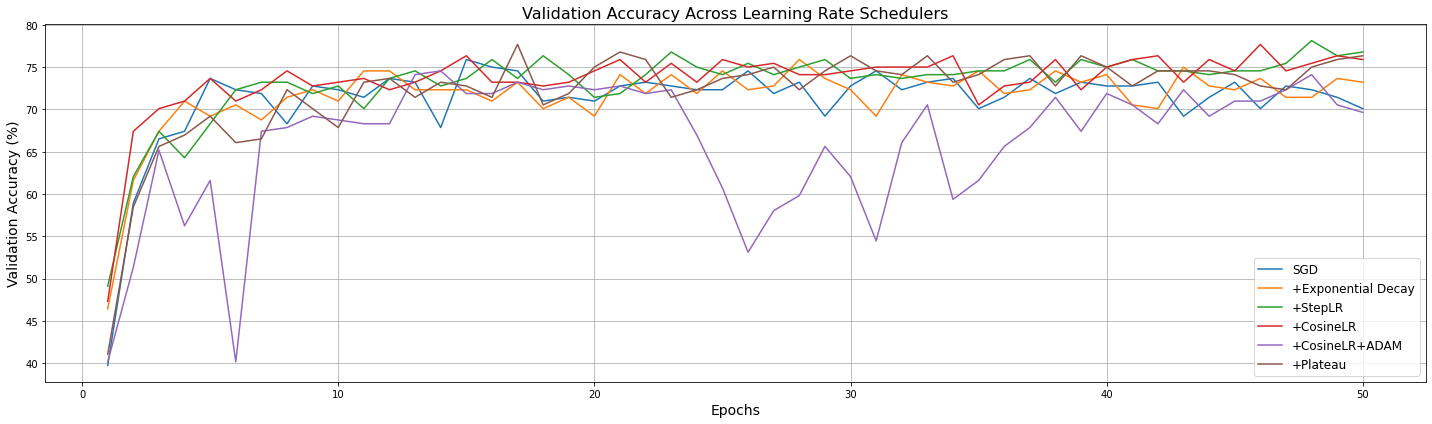

In [76]:
# Set a larger figure size to take full width
plt.figure(figsize=(20, 6))  # Adjust width and height as needed

# Plot the validation accuracy for different configurations
sns.lineplot(data=training_history18_fc_results, x="epoch", y="val_accuracy", label="SGD")
sns.lineplot(data=training_history18_fc_results_expolr, x="epoch", y="val_accuracy", label="+Exponential Decay")
sns.lineplot(data=training_history18_fc_results_steplr, x="epoch", y="val_accuracy", label="+StepLR")
sns.lineplot(data=training_history18_fc_results_coslr, x="epoch", y="val_accuracy", label="+CosineLR")
sns.lineplot(data=training_history18_fc_results_coslr_adam, x="epoch", y="val_accuracy", label="+CosineLR+ADAM")
sns.lineplot(data=training_history18_fc_results_plateau, x="epoch", y="val_accuracy", label="+Plateau")

# Add title, labels, legend, and grid for better visualization
plt.title("Validation Accuracy Across Learning Rate Schedulers", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Validation Accuracy (%)", fontsize=14)
plt.legend(fontsize=12, loc="best")
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

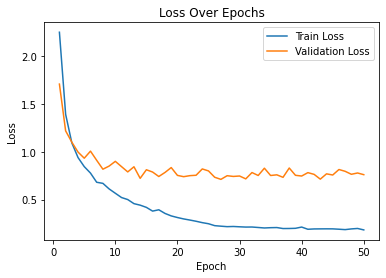

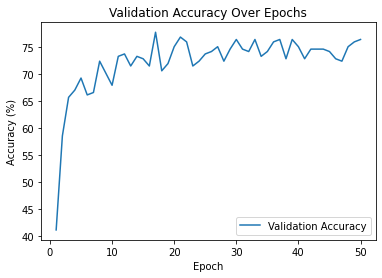

In [24]:
# Plot training and validation loss
import seaborn as sns
import matplotlib.pyplot as plt

history_df = training_history18_fc_results_plateau

sns.lineplot(data=history_df, x="epoch", y="train_loss", label="Train Loss")
sns.lineplot(data=history_df, x="epoch", y="val_loss", label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot validation accuracy
sns.lineplot(data=history_df, x="epoch", y="val_accuracy", label="Validation Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

In [33]:
# Save the trained model
model_path = "trained_model18_fc_results_steplr.pth"
torch.save(trained_model18_fc_results_steplr.state_dict(), model_path)

print(f"Model saved to {model_path}.")

Model saved to trained_model18_fc_results_steplr.pth.


In [41]:
# Reset weights
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [ ]:
pip install optuna

In [55]:
import optuna
import torch
import torch.nn as nn
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-3)
    step_size = trial.suggest_int('step_size', 1, 10)
    gamma = trial.suggest_float('gamma', 0.2, 0.6)
    batch_size = trial.suggest_categorical('batch_size', [32])

    # Recreate DataLoaders with new batch_size
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size)

    # Load ResNet18 model
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, len(train_dataset.classes))
    model = model.to(device)

    # Optimizer and Scheduler
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    criterion = nn.CrossEntropyLoss()

    # Training and Validation
    _, history = train_network_lrs(
        model=model,
        loss_func=criterion,
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=10,  # Shortened for tuning
        device=device,
        optimizer=optimizer,
        lr_schedule=scheduler,
        score_funcs={'Accuracy': accuracy_score}
    )

    # Return best validation accuracy
    return max(history['val_accuracy'])

In [56]:
# Create an Optuna study
study = optuna.create_study(direction="maximize")  # We want to maximize validation accuracy
study.optimize(objective, n_trials=10)

# Print the best trial
print("Best trial:")
trial = study.best_trial
print(f"  Accuracy: {trial.value}")
print("  Best parameters:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-11-26 22:04:36,480] A new study created in memory with name: no-name-4d238e7a-1bcf-4477-9efd-3416f965a9e3
/tmp/ipykernel_215824/1813555279.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipykernel_215824/1813555279.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-3)
Epoch:  10%|█         | 1/10 [00:40<06:06, 40.73s/it]

Epoch 1/10, Train Loss: 1.4524, Train Accuracy: 50.22%, Val Loss: 1.1419, Val Accuracy: 63.84%


Epoch:  20%|██        | 2/10 [01:21<05:26, 40.80s/it]

Epoch 2/10, Train Loss: 1.0147, Train Accuracy: 63.08%, Val Loss: 1.1349, Val Accuracy: 59.82%


Epoch:  30%|███       | 3/10 [02:01<04:44, 40.58s/it]

Epoch 3/10, Train Loss: 0.7780, Train Accuracy: 72.21%, Val Loss: 1.0815, Val Accuracy: 65.18%


Epoch:  40%|████      | 4/10 [02:43<04:06, 41.15s/it]

Epoch 4/10, Train Loss: 0.6557, Train Accuracy: 76.33%, Val Loss: 0.9777, Val Accuracy: 63.39%


Epoch:  50%|█████     | 5/10 [03:24<03:24, 40.89s/it]

Epoch 5/10, Train Loss: 0.5710, Train Accuracy: 78.31%, Val Loss: 1.2499, Val Accuracy: 62.05%


Epoch:  60%|██████    | 6/10 [04:04<02:43, 40.77s/it]

Epoch 6/10, Train Loss: 0.4285, Train Accuracy: 83.52%, Val Loss: 0.9643, Val Accuracy: 63.84%


Epoch:  70%|███████   | 7/10 [04:45<02:01, 40.60s/it]

Epoch 7/10, Train Loss: 0.3286, Train Accuracy: 87.05%, Val Loss: 0.7887, Val Accuracy: 68.75%


Epoch:  80%|████████  | 8/10 [05:25<01:20, 40.43s/it]

Epoch 8/10, Train Loss: 0.2755, Train Accuracy: 88.64%, Val Loss: 0.8260, Val Accuracy: 71.43%


Epoch:  90%|█████████ | 9/10 [06:06<00:40, 40.82s/it]

Epoch 9/10, Train Loss: 0.2785, Train Accuracy: 88.64%, Val Loss: 0.9492, Val Accuracy: 66.96%


Epoch: 100%|██████████| 10/10 [06:47<00:00, 40.74s/it]
[I 2024-11-26 22:11:23,983] Trial 0 finished with value: 72.76785714285714 and parameters: {'lr': 0.004935335403503916, 'weight_decay': 0.000401008466035112, 'step_size': 5, 'gamma': 0.5793540594350997, 'batch_size': 32}. Best is trial 0 with value: 72.76785714285714.
/tmp/ipykernel_215824/1813555279.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipykernel_215824/1813555279.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-3)


Epoch 10/10, Train Loss: 0.2269, Train Accuracy: 89.73%, Val Loss: 0.8900, Val Accuracy: 72.77%


Epoch:  10%|█         | 1/10 [00:40<06:02, 40.31s/it]

Epoch 1/10, Train Loss: 1.7484, Train Accuracy: 37.42%, Val Loss: 1.3996, Val Accuracy: 57.14%


Epoch:  20%|██        | 2/10 [01:20<05:21, 40.19s/it]

Epoch 2/10, Train Loss: 1.1755, Train Accuracy: 60.89%, Val Loss: 1.0187, Val Accuracy: 66.52%


Epoch:  30%|███       | 3/10 [02:00<04:41, 40.27s/it]

Epoch 3/10, Train Loss: 0.9473, Train Accuracy: 67.89%, Val Loss: 0.9678, Val Accuracy: 65.62%


Epoch:  40%|████      | 4/10 [02:41<04:01, 40.30s/it]

Epoch 4/10, Train Loss: 0.8164, Train Accuracy: 72.95%, Val Loss: 0.8933, Val Accuracy: 70.09%


Epoch:  50%|█████     | 5/10 [03:21<03:21, 40.33s/it]

Epoch 5/10, Train Loss: 0.7558, Train Accuracy: 74.24%, Val Loss: 0.9174, Val Accuracy: 69.64%


Epoch:  60%|██████    | 6/10 [04:01<02:41, 40.29s/it]

Epoch 6/10, Train Loss: 0.7312, Train Accuracy: 74.74%, Val Loss: 0.8553, Val Accuracy: 71.43%


Epoch:  70%|███████   | 7/10 [04:41<02:00, 40.15s/it]

Epoch 7/10, Train Loss: 0.6965, Train Accuracy: 75.53%, Val Loss: 0.8850, Val Accuracy: 71.88%


Epoch:  80%|████████  | 8/10 [05:21<01:20, 40.18s/it]

Epoch 8/10, Train Loss: 0.6722, Train Accuracy: 76.97%, Val Loss: 0.8556, Val Accuracy: 70.98%


Epoch:  90%|█████████ | 9/10 [06:01<00:40, 40.17s/it]

Epoch 9/10, Train Loss: 0.6581, Train Accuracy: 77.17%, Val Loss: 0.8317, Val Accuracy: 69.64%


Epoch: 100%|██████████| 10/10 [06:42<00:00, 40.20s/it]
[I 2024-11-26 22:18:06,160] Trial 1 finished with value: 74.10714285714286 and parameters: {'lr': 0.0007472408424949306, 'weight_decay': 0.0004529346242098788, 'step_size': 3, 'gamma': 0.42192945668124926, 'batch_size': 32}. Best is trial 1 with value: 74.10714285714286.
/tmp/ipykernel_215824/1813555279.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipykernel_215824/1813555279.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-3)


Epoch 10/10, Train Loss: 0.6229, Train Accuracy: 79.40%, Val Loss: 0.8239, Val Accuracy: 74.11%


Epoch:  10%|█         | 1/10 [00:40<06:04, 40.49s/it]

Epoch 1/10, Train Loss: 1.5324, Train Accuracy: 47.84%, Val Loss: 2.2863, Val Accuracy: 32.59%


Epoch:  20%|██        | 2/10 [01:20<05:22, 40.31s/it]

Epoch 2/10, Train Loss: 1.2591, Train Accuracy: 57.22%, Val Loss: 1.5359, Val Accuracy: 49.55%


Epoch:  30%|███       | 3/10 [02:00<04:42, 40.29s/it]

Epoch 3/10, Train Loss: 0.9909, Train Accuracy: 66.65%, Val Loss: 1.1375, Val Accuracy: 64.29%


Epoch:  40%|████      | 4/10 [02:41<04:01, 40.29s/it]

Epoch 4/10, Train Loss: 0.8771, Train Accuracy: 69.38%, Val Loss: 1.1024, Val Accuracy: 61.16%


Epoch:  50%|█████     | 5/10 [03:21<03:21, 40.35s/it]

Epoch 5/10, Train Loss: 0.7159, Train Accuracy: 73.15%, Val Loss: 0.9115, Val Accuracy: 70.54%


Epoch:  60%|██████    | 6/10 [04:02<02:41, 40.38s/it]

Epoch 6/10, Train Loss: 0.4443, Train Accuracy: 82.48%, Val Loss: 0.7941, Val Accuracy: 70.54%


Epoch:  70%|███████   | 7/10 [04:42<02:01, 40.39s/it]

Epoch 7/10, Train Loss: 0.3811, Train Accuracy: 85.71%, Val Loss: 0.9114, Val Accuracy: 68.30%


Epoch:  80%|████████  | 8/10 [05:22<01:20, 40.30s/it]

Epoch 8/10, Train Loss: 0.3568, Train Accuracy: 85.41%, Val Loss: 0.9290, Val Accuracy: 73.66%


Epoch:  90%|█████████ | 9/10 [06:03<00:40, 40.45s/it]

Epoch 9/10, Train Loss: 0.3008, Train Accuracy: 87.10%, Val Loss: 0.9567, Val Accuracy: 73.21%


Epoch: 100%|██████████| 10/10 [06:44<00:00, 40.45s/it]
[I 2024-11-26 22:24:50,791] Trial 2 finished with value: 73.66071428571429 and parameters: {'lr': 0.0063788732215298285, 'weight_decay': 0.0004980876193802927, 'step_size': 5, 'gamma': 0.512155090992847, 'batch_size': 32}. Best is trial 1 with value: 74.10714285714286.
/tmp/ipykernel_215824/1813555279.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipykernel_215824/1813555279.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-3)


Epoch 10/10, Train Loss: 0.2577, Train Accuracy: 89.63%, Val Loss: 0.8789, Val Accuracy: 72.32%


Epoch:  10%|█         | 1/10 [00:40<06:06, 40.76s/it]

Epoch 1/10, Train Loss: 1.4020, Train Accuracy: 50.37%, Val Loss: 1.2035, Val Accuracy: 58.04%


Epoch:  20%|██        | 2/10 [01:20<05:21, 40.23s/it]

Epoch 2/10, Train Loss: 0.9958, Train Accuracy: 64.91%, Val Loss: 1.0691, Val Accuracy: 64.73%


Epoch:  30%|███       | 3/10 [02:00<04:42, 40.29s/it]

Epoch 3/10, Train Loss: 0.7804, Train Accuracy: 70.82%, Val Loss: 0.9959, Val Accuracy: 66.07%


Epoch:  40%|████      | 4/10 [02:41<04:02, 40.40s/it]

Epoch 4/10, Train Loss: 0.6278, Train Accuracy: 76.33%, Val Loss: 0.8912, Val Accuracy: 68.30%


Epoch:  50%|█████     | 5/10 [03:22<03:22, 40.45s/it]

Epoch 5/10, Train Loss: 0.5435, Train Accuracy: 79.26%, Val Loss: 1.1398, Val Accuracy: 62.95%


Epoch:  60%|██████    | 6/10 [04:02<02:41, 40.30s/it]

Epoch 6/10, Train Loss: 0.4921, Train Accuracy: 81.79%, Val Loss: 0.9677, Val Accuracy: 68.30%


Epoch:  70%|███████   | 7/10 [04:42<02:01, 40.43s/it]

Epoch 7/10, Train Loss: 0.4277, Train Accuracy: 82.38%, Val Loss: 0.9851, Val Accuracy: 68.30%


Epoch:  80%|████████  | 8/10 [05:22<01:20, 40.33s/it]

Epoch 8/10, Train Loss: 0.3908, Train Accuracy: 84.27%, Val Loss: 1.1742, Val Accuracy: 67.41%


Epoch:  90%|█████████ | 9/10 [06:04<00:40, 40.59s/it]

Epoch 9/10, Train Loss: 0.3769, Train Accuracy: 84.71%, Val Loss: 0.7813, Val Accuracy: 75.00%


Epoch: 100%|██████████| 10/10 [06:44<00:00, 40.44s/it]
[I 2024-11-26 22:31:35,307] Trial 3 finished with value: 75.0 and parameters: {'lr': 0.004471556094091022, 'weight_decay': 0.0002314070721719079, 'step_size': 9, 'gamma': 0.5283575144848734, 'batch_size': 32}. Best is trial 3 with value: 75.0.
/tmp/ipykernel_215824/1813555279.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipykernel_215824/1813555279.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-3)


Epoch 10/10, Train Loss: 0.2560, Train Accuracy: 89.33%, Val Loss: 0.7897, Val Accuracy: 75.00%


Epoch:  10%|█         | 1/10 [00:40<06:02, 40.29s/it]

Epoch 1/10, Train Loss: 1.5111, Train Accuracy: 49.63%, Val Loss: 1.3753, Val Accuracy: 50.45%


Epoch:  20%|██        | 2/10 [01:20<05:21, 40.15s/it]

Epoch 2/10, Train Loss: 0.9008, Train Accuracy: 67.30%, Val Loss: 0.9646, Val Accuracy: 69.64%


Epoch:  30%|███       | 3/10 [02:00<04:41, 40.20s/it]

Epoch 3/10, Train Loss: 0.6388, Train Accuracy: 76.67%, Val Loss: 0.8586, Val Accuracy: 72.32%


Epoch:  40%|████      | 4/10 [02:41<04:02, 40.50s/it]

Epoch 4/10, Train Loss: 0.5212, Train Accuracy: 80.55%, Val Loss: 0.7952, Val Accuracy: 71.43%


Epoch:  50%|█████     | 5/10 [03:23<03:24, 40.87s/it]

Epoch 5/10, Train Loss: 0.4661, Train Accuracy: 83.52%, Val Loss: 0.7545, Val Accuracy: 75.00%


Epoch:  60%|██████    | 6/10 [04:03<02:42, 40.59s/it]

Epoch 6/10, Train Loss: 0.4291, Train Accuracy: 84.22%, Val Loss: 0.7165, Val Accuracy: 75.45%


Epoch:  70%|███████   | 7/10 [04:44<02:02, 40.78s/it]

Epoch 7/10, Train Loss: 0.4119, Train Accuracy: 84.86%, Val Loss: 0.7398, Val Accuracy: 73.21%


Epoch:  80%|████████  | 8/10 [05:24<01:21, 40.74s/it]

Epoch 8/10, Train Loss: 0.4047, Train Accuracy: 86.20%, Val Loss: 0.7405, Val Accuracy: 74.55%


Epoch:  90%|█████████ | 9/10 [06:05<00:40, 40.59s/it]

Epoch 9/10, Train Loss: 0.4115, Train Accuracy: 84.86%, Val Loss: 0.7334, Val Accuracy: 74.11%


Epoch: 100%|██████████| 10/10 [06:45<00:00, 40.55s/it]
[I 2024-11-26 22:38:20,903] Trial 4 finished with value: 75.44642857142857 and parameters: {'lr': 0.005518578027967121, 'weight_decay': 0.0002574018006930017, 'step_size': 1, 'gamma': 0.5184952635031717, 'batch_size': 32}. Best is trial 4 with value: 75.44642857142857.
/tmp/ipykernel_215824/1813555279.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipykernel_215824/1813555279.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-3)


Epoch 10/10, Train Loss: 0.4031, Train Accuracy: 85.86%, Val Loss: 0.7407, Val Accuracy: 71.88%


Epoch:  10%|█         | 1/10 [00:40<06:06, 40.71s/it]

Epoch 1/10, Train Loss: 2.0364, Train Accuracy: 22.38%, Val Loss: 1.9073, Val Accuracy: 28.57%


Epoch:  20%|██        | 2/10 [01:21<05:24, 40.53s/it]

Epoch 2/10, Train Loss: 1.7489, Train Accuracy: 39.60%, Val Loss: 1.6977, Val Accuracy: 43.75%


Epoch:  30%|███       | 3/10 [02:01<04:43, 40.48s/it]

Epoch 3/10, Train Loss: 1.5542, Train Accuracy: 50.32%, Val Loss: 1.5215, Val Accuracy: 50.45%


Epoch:  40%|████      | 4/10 [02:42<04:03, 40.61s/it]

Epoch 4/10, Train Loss: 1.4451, Train Accuracy: 54.54%, Val Loss: 1.4802, Val Accuracy: 55.80%


Epoch:  50%|█████     | 5/10 [03:25<03:27, 41.43s/it]

Epoch 5/10, Train Loss: 1.3739, Train Accuracy: 56.58%, Val Loss: 1.4185, Val Accuracy: 55.36%


Epoch:  60%|██████    | 6/10 [04:05<02:44, 41.15s/it]

Epoch 6/10, Train Loss: 1.3105, Train Accuracy: 58.26%, Val Loss: 1.3570, Val Accuracy: 58.48%


Epoch:  70%|███████   | 7/10 [04:46<02:03, 41.12s/it]

Epoch 7/10, Train Loss: 1.2791, Train Accuracy: 60.10%, Val Loss: 1.3344, Val Accuracy: 56.70%


Epoch:  80%|████████  | 8/10 [05:27<01:21, 40.94s/it]

Epoch 8/10, Train Loss: 1.2496, Train Accuracy: 59.75%, Val Loss: 1.2890, Val Accuracy: 61.16%


Epoch:  90%|█████████ | 9/10 [06:08<00:40, 40.84s/it]

Epoch 9/10, Train Loss: 1.2239, Train Accuracy: 60.00%, Val Loss: 1.2778, Val Accuracy: 58.48%


Epoch: 100%|██████████| 10/10 [06:50<00:00, 41.06s/it]
[I 2024-11-26 22:45:11,668] Trial 5 finished with value: 61.160714285714285 and parameters: {'lr': 0.0001317084739991766, 'weight_decay': 0.0001050025787793719, 'step_size': 3, 'gamma': 0.5530165405658902, 'batch_size': 32}. Best is trial 4 with value: 75.44642857142857.
/tmp/ipykernel_215824/1813555279.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipykernel_215824/1813555279.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-3)


Epoch 10/10, Train Loss: 1.2051, Train Accuracy: 61.64%, Val Loss: 1.2593, Val Accuracy: 60.71%


Epoch:  10%|█         | 1/10 [00:40<06:02, 40.23s/it]

Epoch 1/10, Train Loss: 1.5619, Train Accuracy: 45.51%, Val Loss: 1.0476, Val Accuracy: 63.39%


Epoch:  20%|██        | 2/10 [01:20<05:21, 40.23s/it]

Epoch 2/10, Train Loss: 0.9471, Train Accuracy: 67.15%, Val Loss: 0.8318, Val Accuracy: 70.54%


Epoch:  30%|███       | 3/10 [02:00<04:41, 40.20s/it]

Epoch 3/10, Train Loss: 0.7749, Train Accuracy: 71.51%, Val Loss: 0.9512, Val Accuracy: 67.86%


Epoch:  40%|████      | 4/10 [02:40<04:01, 40.20s/it]

Epoch 4/10, Train Loss: 0.6232, Train Accuracy: 76.77%, Val Loss: 0.9603, Val Accuracy: 63.39%


Epoch:  50%|█████     | 5/10 [03:21<03:21, 40.24s/it]

Epoch 5/10, Train Loss: 0.5086, Train Accuracy: 81.84%, Val Loss: 0.9679, Val Accuracy: 66.96%


Epoch:  60%|██████    | 6/10 [04:01<02:41, 40.41s/it]

Epoch 6/10, Train Loss: 0.4635, Train Accuracy: 82.43%, Val Loss: 0.9238, Val Accuracy: 71.43%


Epoch:  70%|███████   | 7/10 [04:44<02:03, 41.06s/it]

Epoch 7/10, Train Loss: 0.4084, Train Accuracy: 84.42%, Val Loss: 0.9042, Val Accuracy: 68.75%


Epoch:  80%|████████  | 8/10 [05:24<01:21, 40.88s/it]

Epoch 8/10, Train Loss: 0.3429, Train Accuracy: 86.90%, Val Loss: 0.9658, Val Accuracy: 68.75%


Epoch:  90%|█████████ | 9/10 [06:05<00:40, 40.82s/it]

Epoch 9/10, Train Loss: 0.2982, Train Accuracy: 88.19%, Val Loss: 1.0321, Val Accuracy: 67.86%


Epoch: 100%|██████████| 10/10 [06:46<00:00, 40.60s/it]
[I 2024-11-26 22:51:57,847] Trial 6 finished with value: 71.42857142857143 and parameters: {'lr': 0.0021533162142477894, 'weight_decay': 0.0006806550332048252, 'step_size': 10, 'gamma': 0.28701037822596687, 'batch_size': 32}. Best is trial 4 with value: 75.44642857142857.
/tmp/ipykernel_215824/1813555279.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipykernel_215824/1813555279.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-3)


Epoch 10/10, Train Loss: 0.2528, Train Accuracy: 89.63%, Val Loss: 0.9321, Val Accuracy: 70.54%


Epoch:  10%|█         | 1/10 [00:40<06:03, 40.44s/it]

Epoch 1/10, Train Loss: 2.0446, Train Accuracy: 24.52%, Val Loss: 1.8745, Val Accuracy: 32.59%


Epoch:  20%|██        | 2/10 [01:21<05:24, 40.60s/it]

Epoch 2/10, Train Loss: 1.7433, Train Accuracy: 40.65%, Val Loss: 1.6679, Val Accuracy: 45.09%


Epoch:  30%|███       | 3/10 [02:06<04:58, 42.70s/it]

Epoch 3/10, Train Loss: 1.5805, Train Accuracy: 48.14%, Val Loss: 1.5551, Val Accuracy: 50.00%


Epoch:  40%|████      | 4/10 [02:46<04:10, 41.71s/it]

Epoch 4/10, Train Loss: 1.4509, Train Accuracy: 53.80%, Val Loss: 1.4367, Val Accuracy: 55.80%


Epoch:  50%|█████     | 5/10 [03:26<03:25, 41.20s/it]

Epoch 5/10, Train Loss: 1.3598, Train Accuracy: 56.48%, Val Loss: 1.3657, Val Accuracy: 55.80%


Epoch:  60%|██████    | 6/10 [04:07<02:43, 40.97s/it]

Epoch 6/10, Train Loss: 1.2760, Train Accuracy: 58.26%, Val Loss: 1.2666, Val Accuracy: 59.82%


Epoch:  70%|███████   | 7/10 [04:47<02:02, 40.68s/it]

Epoch 7/10, Train Loss: 1.1998, Train Accuracy: 61.19%, Val Loss: 1.2360, Val Accuracy: 60.27%


Epoch:  80%|████████  | 8/10 [05:30<01:23, 41.59s/it]

Epoch 8/10, Train Loss: 1.1450, Train Accuracy: 62.08%, Val Loss: 1.1426, Val Accuracy: 65.62%


Epoch:  90%|█████████ | 9/10 [06:11<00:41, 41.25s/it]

Epoch 9/10, Train Loss: 1.1022, Train Accuracy: 63.67%, Val Loss: 1.1621, Val Accuracy: 62.95%


Epoch: 100%|██████████| 10/10 [06:51<00:00, 41.19s/it]
[I 2024-11-26 22:58:49,862] Trial 7 finished with value: 66.07142857142857 and parameters: {'lr': 0.0001232797094069426, 'weight_decay': 0.0007220754623324007, 'step_size': 8, 'gamma': 0.5652258123975111, 'batch_size': 32}. Best is trial 4 with value: 75.44642857142857.
/tmp/ipykernel_215824/1813555279.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipykernel_215824/1813555279.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-3)


Epoch 10/10, Train Loss: 1.0663, Train Accuracy: 64.81%, Val Loss: 1.1500, Val Accuracy: 66.07%


Epoch:  10%|█         | 1/10 [00:44<06:41, 44.59s/it]

Epoch 1/10, Train Loss: 1.7652, Train Accuracy: 37.17%, Val Loss: 1.4306, Val Accuracy: 54.46%


Epoch:  20%|██        | 2/10 [01:24<05:36, 42.04s/it]

Epoch 2/10, Train Loss: 1.2314, Train Accuracy: 59.31%, Val Loss: 1.2003, Val Accuracy: 60.71%


Epoch:  30%|███       | 3/10 [02:05<04:48, 41.25s/it]

Epoch 3/10, Train Loss: 1.0002, Train Accuracy: 66.75%, Val Loss: 1.0937, Val Accuracy: 62.50%


Epoch:  40%|████      | 4/10 [02:46<04:07, 41.23s/it]

Epoch 4/10, Train Loss: 0.8810, Train Accuracy: 70.42%, Val Loss: 0.9079, Val Accuracy: 71.43%


Epoch:  50%|█████     | 5/10 [03:28<03:27, 41.51s/it]

Epoch 5/10, Train Loss: 0.7801, Train Accuracy: 74.39%, Val Loss: 0.9813, Val Accuracy: 62.50%


Epoch:  60%|██████    | 6/10 [04:08<02:44, 41.02s/it]

Epoch 6/10, Train Loss: 0.7402, Train Accuracy: 73.40%, Val Loss: 0.8615, Val Accuracy: 71.88%


Epoch:  70%|███████   | 7/10 [04:53<02:06, 42.24s/it]

Epoch 7/10, Train Loss: 0.6509, Train Accuracy: 77.27%, Val Loss: 0.8312, Val Accuracy: 73.21%


Epoch:  80%|████████  | 8/10 [05:34<01:23, 41.83s/it]

Epoch 8/10, Train Loss: 0.5810, Train Accuracy: 79.70%, Val Loss: 0.7732, Val Accuracy: 78.57%


Epoch:  90%|█████████ | 9/10 [06:23<00:44, 44.20s/it]

Epoch 9/10, Train Loss: 0.5754, Train Accuracy: 79.85%, Val Loss: 0.7857, Val Accuracy: 74.11%


Epoch: 100%|██████████| 10/10 [07:03<00:00, 42.37s/it]
[I 2024-11-26 23:05:53,730] Trial 8 finished with value: 78.57142857142857 and parameters: {'lr': 0.0005942299754930928, 'weight_decay': 0.00011039358502519593, 'step_size': 7, 'gamma': 0.350303966670224, 'batch_size': 32}. Best is trial 8 with value: 78.57142857142857.
/tmp/ipykernel_215824/1813555279.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipykernel_215824/1813555279.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-4, 1e-3)


Epoch 10/10, Train Loss: 0.5578, Train Accuracy: 80.69%, Val Loss: 0.7922, Val Accuracy: 71.43%


Epoch:  10%|█         | 1/10 [00:40<06:05, 40.61s/it]

Epoch 1/10, Train Loss: 1.9452, Train Accuracy: 26.30%, Val Loss: 1.7918, Val Accuracy: 37.05%


Epoch:  20%|██        | 2/10 [01:21<05:24, 40.56s/it]

Epoch 2/10, Train Loss: 1.6069, Train Accuracy: 47.10%, Val Loss: 1.5299, Val Accuracy: 53.12%


Epoch:  30%|███       | 3/10 [02:08<05:04, 43.46s/it]

Epoch 3/10, Train Loss: 1.4383, Train Accuracy: 53.75%, Val Loss: 1.4280, Val Accuracy: 57.59%


Epoch:  40%|████      | 4/10 [02:49<04:16, 42.72s/it]

Epoch 4/10, Train Loss: 1.3484, Train Accuracy: 57.57%, Val Loss: 1.3757, Val Accuracy: 58.48%


Epoch:  50%|█████     | 5/10 [03:30<03:29, 41.90s/it]

Epoch 5/10, Train Loss: 1.2891, Train Accuracy: 58.36%, Val Loss: 1.3262, Val Accuracy: 61.61%


Epoch:  60%|██████    | 6/10 [04:12<02:47, 41.93s/it]

Epoch 6/10, Train Loss: 1.2451, Train Accuracy: 59.11%, Val Loss: 1.3124, Val Accuracy: 57.59%


Epoch:  70%|███████   | 7/10 [04:54<02:06, 42.16s/it]

Epoch 7/10, Train Loss: 1.2225, Train Accuracy: 61.94%, Val Loss: 1.3085, Val Accuracy: 60.27%


Epoch:  80%|████████  | 8/10 [05:35<01:23, 41.61s/it]

Epoch 8/10, Train Loss: 1.2010, Train Accuracy: 61.39%, Val Loss: 1.2820, Val Accuracy: 62.95%


Epoch:  90%|█████████ | 9/10 [06:16<00:41, 41.41s/it]

Epoch 9/10, Train Loss: 1.1959, Train Accuracy: 61.39%, Val Loss: 1.2909, Val Accuracy: 59.38%


Epoch: 100%|██████████| 10/10 [06:56<00:00, 41.64s/it]
[I 2024-11-26 23:12:50,308] Trial 9 finished with value: 62.94642857142857 and parameters: {'lr': 0.00022244497679382955, 'weight_decay': 0.00011611622409435207, 'step_size': 2, 'gamma': 0.512350014868461, 'batch_size': 32}. Best is trial 8 with value: 78.57142857142857.


Epoch 10/10, Train Loss: 1.1911, Train Accuracy: 60.74%, Val Loss: 1.2502, Val Accuracy: 62.05%
Best trial:
  Accuracy: 78.57142857142857
  Best parameters:
    lr: 0.0005942299754930928
    weight_decay: 0.00011039358502519593
    step_size: 7
    gamma: 0.350303966670224
    batch_size: 32


In [ ]:
print(study.best_params)

Epoch:   2%|▏         | 1/50 [00:40<33:06, 40.55s/it]

Epoch 1/50, Train Loss: 1.7983, Train Accuracy: 37.52%, Val Loss: 1.4732, Val Accuracy: 53.57%


Epoch:   4%|▍         | 2/50 [01:20<32:22, 40.47s/it]

Epoch 2/50, Train Loss: 1.2828, Train Accuracy: 57.72%, Val Loss: 1.1143, Val Accuracy: 62.50%


Epoch:   6%|▌         | 3/50 [02:01<31:37, 40.37s/it]

Epoch 3/50, Train Loss: 1.0355, Train Accuracy: 65.36%, Val Loss: 0.9985, Val Accuracy: 65.62%


Epoch:   8%|▊         | 4/50 [02:42<31:11, 40.69s/it]

Epoch 4/50, Train Loss: 0.9035, Train Accuracy: 69.88%, Val Loss: 0.9549, Val Accuracy: 68.30%


Epoch:  10%|█         | 5/50 [03:23<30:32, 40.72s/it]

Epoch 5/50, Train Loss: 0.7935, Train Accuracy: 73.20%, Val Loss: 0.9593, Val Accuracy: 68.75%


Epoch:  12%|█▏        | 6/50 [04:03<29:50, 40.69s/it]

Epoch 6/50, Train Loss: 0.7168, Train Accuracy: 75.58%, Val Loss: 0.8290, Val Accuracy: 74.55%


Epoch:  14%|█▍        | 7/50 [04:48<30:11, 42.13s/it]

Epoch 7/50, Train Loss: 0.6509, Train Accuracy: 78.21%, Val Loss: 0.8042, Val Accuracy: 72.32%


Epoch:  16%|█▌        | 8/50 [05:30<29:28, 42.10s/it]

Epoch 8/50, Train Loss: 0.5888, Train Accuracy: 80.00%, Val Loss: 0.7815, Val Accuracy: 72.77%


Epoch:  18%|█▊        | 9/50 [06:11<28:29, 41.69s/it]

Epoch 9/50, Train Loss: 0.5682, Train Accuracy: 79.60%, Val Loss: 0.7396, Val Accuracy: 73.66%


Epoch:  20%|██        | 10/50 [06:54<28:00, 42.00s/it]

Epoch 10/50, Train Loss: 0.5625, Train Accuracy: 80.45%, Val Loss: 0.7609, Val Accuracy: 72.32%


Epoch:  22%|██▏       | 11/50 [07:36<27:13, 41.89s/it]

Epoch 11/50, Train Loss: 0.5350, Train Accuracy: 81.59%, Val Loss: 0.7508, Val Accuracy: 73.66%


Epoch:  24%|██▍       | 12/50 [08:18<26:42, 42.16s/it]

Epoch 12/50, Train Loss: 0.5056, Train Accuracy: 82.93%, Val Loss: 0.7791, Val Accuracy: 70.98%


Epoch:  26%|██▌       | 13/50 [09:01<26:06, 42.34s/it]

Epoch 13/50, Train Loss: 0.5140, Train Accuracy: 82.58%, Val Loss: 0.7467, Val Accuracy: 74.55%


Epoch:  28%|██▊       | 14/50 [09:44<25:29, 42.49s/it]

Epoch 14/50, Train Loss: 0.4830, Train Accuracy: 83.28%, Val Loss: 0.7305, Val Accuracy: 76.34%


Epoch:  30%|███       | 15/50 [10:25<24:27, 41.92s/it]

Epoch 15/50, Train Loss: 0.4774, Train Accuracy: 83.18%, Val Loss: 0.7192, Val Accuracy: 75.00%


Epoch:  32%|███▏      | 16/50 [11:12<24:43, 43.63s/it]

Epoch 16/50, Train Loss: 0.4714, Train Accuracy: 83.82%, Val Loss: 0.7443, Val Accuracy: 73.66%


Epoch:  34%|███▍      | 17/50 [11:54<23:41, 43.07s/it]

Epoch 17/50, Train Loss: 0.4671, Train Accuracy: 83.47%, Val Loss: 0.7170, Val Accuracy: 71.43%


Epoch:  36%|███▌      | 18/50 [12:46<24:25, 45.79s/it]

Epoch 18/50, Train Loss: 0.4512, Train Accuracy: 84.32%, Val Loss: 0.7291, Val Accuracy: 73.21%


Epoch:  38%|███▊      | 19/50 [13:30<23:19, 45.14s/it]

Epoch 19/50, Train Loss: 0.4556, Train Accuracy: 83.92%, Val Loss: 0.7071, Val Accuracy: 73.66%


Epoch:  40%|████      | 20/50 [14:10<21:53, 43.78s/it]

Epoch 20/50, Train Loss: 0.4490, Train Accuracy: 84.47%, Val Loss: 0.7528, Val Accuracy: 71.88%


Epoch:  42%|████▏     | 21/50 [14:51<20:41, 42.82s/it]

Epoch 21/50, Train Loss: 0.4407, Train Accuracy: 85.46%, Val Loss: 0.6833, Val Accuracy: 75.00%


Epoch:  44%|████▍     | 22/50 [15:32<19:44, 42.31s/it]

Epoch 22/50, Train Loss: 0.4327, Train Accuracy: 85.51%, Val Loss: 0.7252, Val Accuracy: 73.66%


Epoch:  46%|████▌     | 23/50 [16:13<18:55, 42.07s/it]

Epoch 23/50, Train Loss: 0.4255, Train Accuracy: 84.96%, Val Loss: 0.7407, Val Accuracy: 75.45%


Epoch:  48%|████▊     | 24/50 [17:02<19:03, 43.97s/it]

Epoch 24/50, Train Loss: 0.4374, Train Accuracy: 85.11%, Val Loss: 0.7353, Val Accuracy: 74.55%


Epoch:  50%|█████     | 25/50 [17:45<18:11, 43.66s/it]

Epoch 25/50, Train Loss: 0.4212, Train Accuracy: 85.61%, Val Loss: 0.7084, Val Accuracy: 74.55%


Epoch:  52%|█████▏    | 26/50 [18:26<17:13, 43.05s/it]

Epoch 26/50, Train Loss: 0.4337, Train Accuracy: 85.16%, Val Loss: 0.7213, Val Accuracy: 76.34%


Epoch:  54%|█████▍    | 27/50 [19:10<16:31, 43.12s/it]

Epoch 27/50, Train Loss: 0.4441, Train Accuracy: 84.62%, Val Loss: 0.6942, Val Accuracy: 75.45%


Epoch:  56%|█████▌    | 28/50 [19:54<15:54, 43.41s/it]

Epoch 28/50, Train Loss: 0.4237, Train Accuracy: 85.46%, Val Loss: 0.6799, Val Accuracy: 74.11%


Epoch:  58%|█████▊    | 29/50 [20:40<15:32, 44.39s/it]

Epoch 29/50, Train Loss: 0.4196, Train Accuracy: 85.26%, Val Loss: 0.7478, Val Accuracy: 71.88%


Epoch:  60%|██████    | 30/50 [21:21<14:26, 43.34s/it]

Epoch 30/50, Train Loss: 0.4370, Train Accuracy: 84.81%, Val Loss: 0.7213, Val Accuracy: 70.98%


Epoch:  62%|██████▏   | 31/50 [22:03<13:33, 42.84s/it]

Epoch 31/50, Train Loss: 0.4233, Train Accuracy: 85.86%, Val Loss: 0.7612, Val Accuracy: 72.77%


Epoch:  64%|██████▍   | 32/50 [22:44<12:42, 42.39s/it]

Epoch 32/50, Train Loss: 0.4242, Train Accuracy: 85.11%, Val Loss: 0.6909, Val Accuracy: 78.12%


Epoch:  66%|██████▌   | 33/50 [23:25<11:53, 41.94s/it]

Epoch 33/50, Train Loss: 0.4231, Train Accuracy: 85.86%, Val Loss: 0.7680, Val Accuracy: 72.32%


Epoch:  68%|██████▊   | 34/50 [24:08<11:15, 42.23s/it]

Epoch 34/50, Train Loss: 0.4233, Train Accuracy: 85.46%, Val Loss: 0.7011, Val Accuracy: 75.45%


Epoch:  70%|███████   | 35/50 [24:51<10:34, 42.32s/it]

Epoch 35/50, Train Loss: 0.4170, Train Accuracy: 85.56%, Val Loss: 0.7169, Val Accuracy: 76.34%


Epoch:  72%|███████▏  | 36/50 [25:33<09:53, 42.38s/it]

Epoch 36/50, Train Loss: 0.4297, Train Accuracy: 84.71%, Val Loss: 0.7118, Val Accuracy: 75.45%


Epoch:  74%|███████▍  | 37/50 [26:15<09:08, 42.23s/it]

Epoch 37/50, Train Loss: 0.4220, Train Accuracy: 85.61%, Val Loss: 0.7346, Val Accuracy: 74.55%


Epoch:  76%|███████▌  | 38/50 [26:56<08:22, 41.85s/it]

Epoch 38/50, Train Loss: 0.4206, Train Accuracy: 85.51%, Val Loss: 0.7177, Val Accuracy: 73.66%


Epoch:  78%|███████▊  | 39/50 [27:37<07:36, 41.47s/it]

Epoch 39/50, Train Loss: 0.4128, Train Accuracy: 85.31%, Val Loss: 0.7349, Val Accuracy: 72.32%


Epoch:  80%|████████  | 40/50 [28:17<06:52, 41.21s/it]

Epoch 40/50, Train Loss: 0.4162, Train Accuracy: 85.41%, Val Loss: 0.7453, Val Accuracy: 73.66%


Epoch:  82%|████████▏ | 41/50 [28:58<06:09, 41.06s/it]

Epoch 41/50, Train Loss: 0.4131, Train Accuracy: 86.20%, Val Loss: 0.7269, Val Accuracy: 76.34%


Epoch:  84%|████████▍ | 42/50 [29:39<05:27, 40.98s/it]

Epoch 42/50, Train Loss: 0.4166, Train Accuracy: 85.16%, Val Loss: 0.7345, Val Accuracy: 71.88%


Epoch:  86%|████████▌ | 43/50 [30:24<04:55, 42.25s/it]

Epoch 43/50, Train Loss: 0.4383, Train Accuracy: 84.76%, Val Loss: 0.7466, Val Accuracy: 72.77%


Epoch:  88%|████████▊ | 44/50 [31:05<04:10, 41.78s/it]

Epoch 44/50, Train Loss: 0.4107, Train Accuracy: 86.40%, Val Loss: 0.7185, Val Accuracy: 73.21%


Epoch:  90%|█████████ | 45/50 [31:50<03:33, 42.79s/it]

Epoch 45/50, Train Loss: 0.4321, Train Accuracy: 85.21%, Val Loss: 0.7021, Val Accuracy: 74.55%


Epoch:  92%|█████████▏| 46/50 [32:30<02:48, 42.12s/it]

Epoch 46/50, Train Loss: 0.4222, Train Accuracy: 85.46%, Val Loss: 0.7296, Val Accuracy: 73.21%


Epoch:  94%|█████████▍| 47/50 [33:11<02:05, 41.72s/it]

Epoch 47/50, Train Loss: 0.4247, Train Accuracy: 85.41%, Val Loss: 0.7260, Val Accuracy: 75.00%


Epoch:  96%|█████████▌| 48/50 [33:54<01:23, 41.94s/it]

Epoch 48/50, Train Loss: 0.4175, Train Accuracy: 85.71%, Val Loss: 0.7359, Val Accuracy: 74.55%


Epoch:  98%|█████████▊| 49/50 [34:35<00:41, 41.73s/it]

Epoch 49/50, Train Loss: 0.4427, Train Accuracy: 84.86%, Val Loss: 0.6965, Val Accuracy: 75.45%


Epoch: 100%|██████████| 50/50 [35:16<00:00, 42.33s/it]

Epoch 50/50, Train Loss: 0.4206, Train Accuracy: 85.51%, Val Loss: 0.7368, Val Accuracy: 73.21%


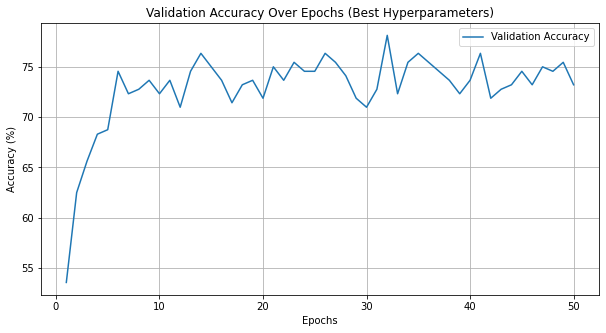

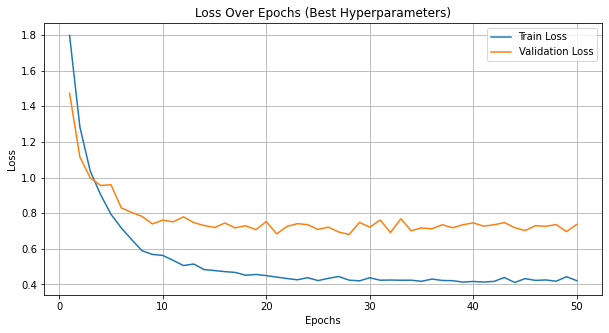

In [61]:
from torch.optim import AdamW, SGD
import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve best hyperparameters
best_params = study.best_params

# Load ResNet18 model
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.classes))
model = model.to(device)

# Apply gradient clipping
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -5, 5))  # Clipping gradients to range [-5, 5]


# Define learning rate scheduler
epochs = 50  # Final training with more epochs

# Optimizer and Scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=best_params["lr"], momentum=0.9, weight_decay=best_params["weight_decay"])
scheduler = StepLR(optimizer, step_size=best_params["step_size"], gamma=best_params["gamma"])
criterion = nn.CrossEntropyLoss()

# Define the loss function
loss_func = nn.CrossEntropyLoss()

# Train the model with the best hyperparameters
model_resnet, results_resnet = train_network_lrs(
    model=model,
    loss_func=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=None,  # Optional test loader
    epochs=epochs,
    device=device,
    optimizer=optimizer,
    lr_schedule=scheduler,
    checkpoint_file="best_resnet_model34.pth"  # Save the best model checkpoint
)
# Plot validation accuracy
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_resnet, x='epoch', y='val_accuracy', label='Validation Accuracy')
plt.title("Validation Accuracy Over Epochs (Best Hyperparameters)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_resnet, x='epoch', y='train_loss', label='Train Loss')
sns.lineplot(data=results_resnet, x='epoch', y='val_loss', label='Validation Loss')
plt.title("Loss Over Epochs (Best Hyperparameters)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

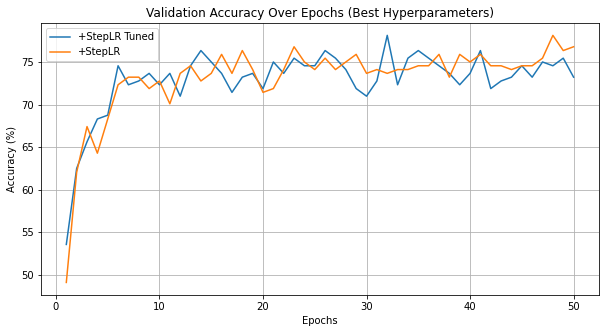

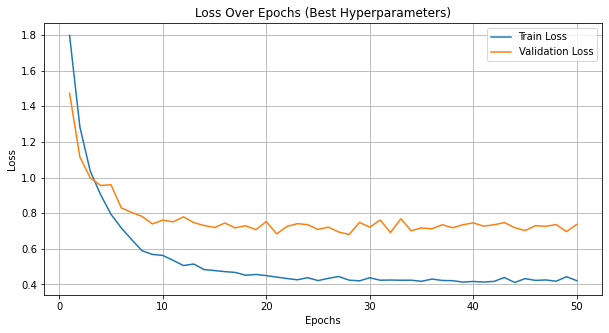

In [78]:
# Plot validation accuracy
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_resnet, x='epoch', y='val_accuracy', label='+StepLR Tuned')
sns.lineplot(data=training_history18_fc_results_steplr, x="epoch", y="val_accuracy", label="+StepLR")
plt.title("Validation Accuracy Over Epochs (Best Hyperparameters)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
sns.lineplot(data=results_resnet, x='epoch', y='train_loss', label='Train Loss')
sns.lineplot(data=results_resnet, x='epoch', y='val_loss', label='Validation Loss')
plt.title("Loss Over Epochs (Best Hyperparameters)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# Save the tuned model
model_path = "model_resnet_tuned.pth"
torch.save(model_resnet.state_dict(), model_path)

print(f"Model saved to {model_path}.")

Model saved to model_resnet_tuned.pth.


In [22]:
# Load the saved model
model, _ = get_new_model()

In [23]:
# Import additional necessary libraries
import matplotlib.pyplot as plt
# Step 1: Load the saved model
model_path = "model_resnet_tuned.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode

# Step 2: Define a function to make predictions on a single image
def predict_image(image_path, model, transform, class_names):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Make predictions
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    # Get the predicted class
    predicted_class = class_names[predicted.item()]

    # Show the image with the predicted label
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

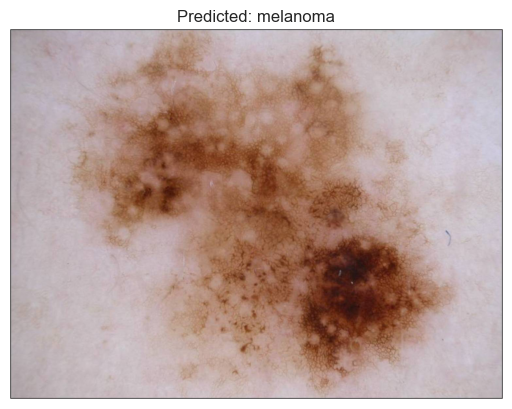

In [27]:
image_path = "data/Test/melanoma/ISIC_0000049.jpg"  # Update this to your test image path
class_names = train_dataset.classes  # Class names from the training dataset
transform_val = transform['val']  # Use the validation transform for preprocessing

# Predict and display the image with the label
predicted_label = predict_image(image_path, model, transform_val, class_names)

In [28]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Assuming `model`, `device`, and `class_names` are already defined

# Step 1: Load the saved model
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode

# Step 2: Define a function to predict the top three classes for a single image
def predict_top3(image_path, model, transform, class_names):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Make predictions
    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output[0], dim=0)  # Apply softmax to get probabilities
        top3_prob, top3_indices = torch.topk(probabilities, 3)  # Get top 3 predictions

    # Get the predicted class labels and probabilities
    top3_classes = [class_names[idx.item()] for idx in top3_indices]
    top3_probabilities = top3_prob.cpu().numpy()

    # Show the image with the top prediction and probabilities
    plt.imshow(image)
    plt.title(f"Top Prediction: {top3_classes[0]}\nProb: {top3_probabilities[0]:.2f}")
    plt.axis('off')
    plt.show()

    # Print top 3 predictions with probabilities
    print("Top 3 Predictions:")
    for cls, prob in zip(top3_classes, top3_probabilities):
        print(f"Class: {cls}, Probability: {prob:.4f}")

    return top3_classes, top3_probabilities


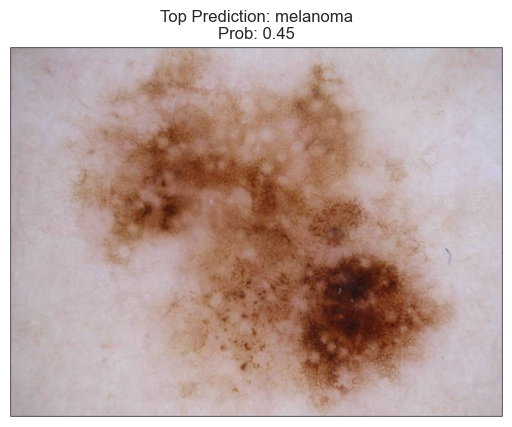

Top 3 Predictions:
Class: melanoma, Probability: 0.4481
Class: nevus, Probability: 0.2803
Class: pigmented benign keratosis, Probability: 0.2368


(['melanoma', 'nevus', 'pigmented benign keratosis'],
 array([0.44813114, 0.28026906, 0.2368423 ], dtype=float32))

In [29]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Adjust as per your model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class_names = train_dataset.classes  # Replace with your class labels
predict_top3(image_path, model, transform, class_names)

In [30]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


# Validate the model on the full training dataset
def validate_model(model, data_loader, device):
    model.eval()  # Set the model to evaluation mode
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred

# Get true and predicted labels
y_true, y_pred = validate_model(model, val_loader, device)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Generate classification report
report = classification_report(y_true, y_pred, target_names=train_dataset.classes)
print("Classification Report:\n", report)

Accuracy: 73.66%
Classification Report:
                             precision    recall  f1-score   support

         actinic keratosis       0.50      0.54      0.52        13
      basal cell carcinoma       0.84      0.88      0.86        42
            dermatofibroma       0.60      0.55      0.57        11
                  melanoma       0.71      0.91      0.80        35
                     nevus       0.78      0.56      0.65        32
pigmented benign keratosis       0.79      0.84      0.82        50
      seborrheic keratosis       0.00      0.00      0.00         8
   squamous cell carcinoma       0.40      0.53      0.46        15
           vascular lesion       1.00      0.83      0.91        18

                  accuracy                           0.74       224
                 macro avg       0.63      0.63      0.62       224
              weighted avg       0.72      0.74      0.72       224



/opt/miniconda3/envs/conda3-11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/conda3-11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/conda3-11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [31]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[ 7  1  2  0  1  1  0  1  0]
 [ 0 37  0  0  0  2  0  3  0]
 [ 0  2  6  0  0  2  0  1  0]
 [ 0  0  0 32  3  0  0  0  0]
 [ 4  1  0  5 18  3  0  1  0]
 [ 0  1  0  0  1 42  0  6  0]
 [ 0  0  0  8  0  0  0  0  0]
 [ 3  1  1  0  0  2  0  8  0]
 [ 0  1  1  0  0  1  0  0 15]]


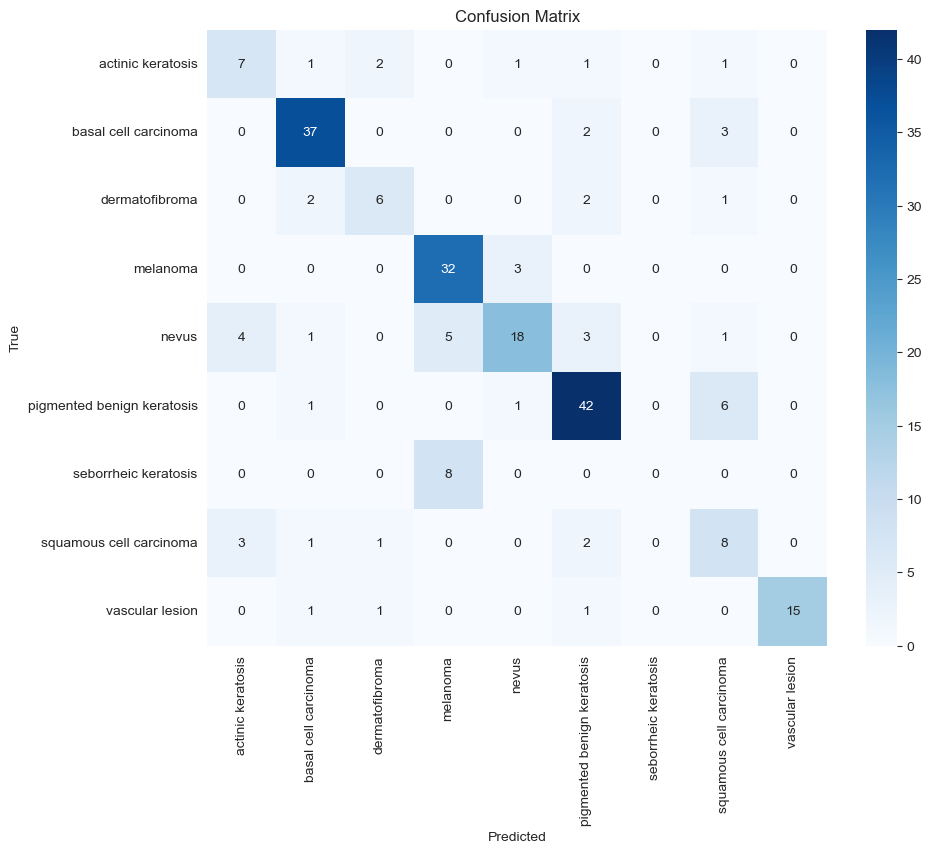

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [35]:
import matplotlib.pyplot as plt

def show_misclassified_images(model, data_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    misclassified_images = []
    correct_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Get misclassified images
            misclassified_idx = (predicted != labels).nonzero(as_tuple=True)[0]
            misclassified_images.extend(images[misclassified_idx])
            correct_labels.extend(labels[misclassified_idx].cpu().numpy())
            predicted_labels.extend(predicted[misclassified_idx].cpu().numpy())

    # Display misclassified images with original and predicted labels
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i, (image, correct, predicted) in enumerate(zip(misclassified_images[:10], correct_labels[:10], predicted_labels[:10])):
        image = image.permute(1, 2, 0).cpu().numpy()  # Ensure the tensor has 3 dimensions
        axes[i // 5, i % 5].imshow(image)
        axes[i // 5, i % 5].axis('off')
        axes[i // 5, i % 5].set_title(f"Actual: {class_names[correct]}\nPredicted: {class_names[predicted]}")

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

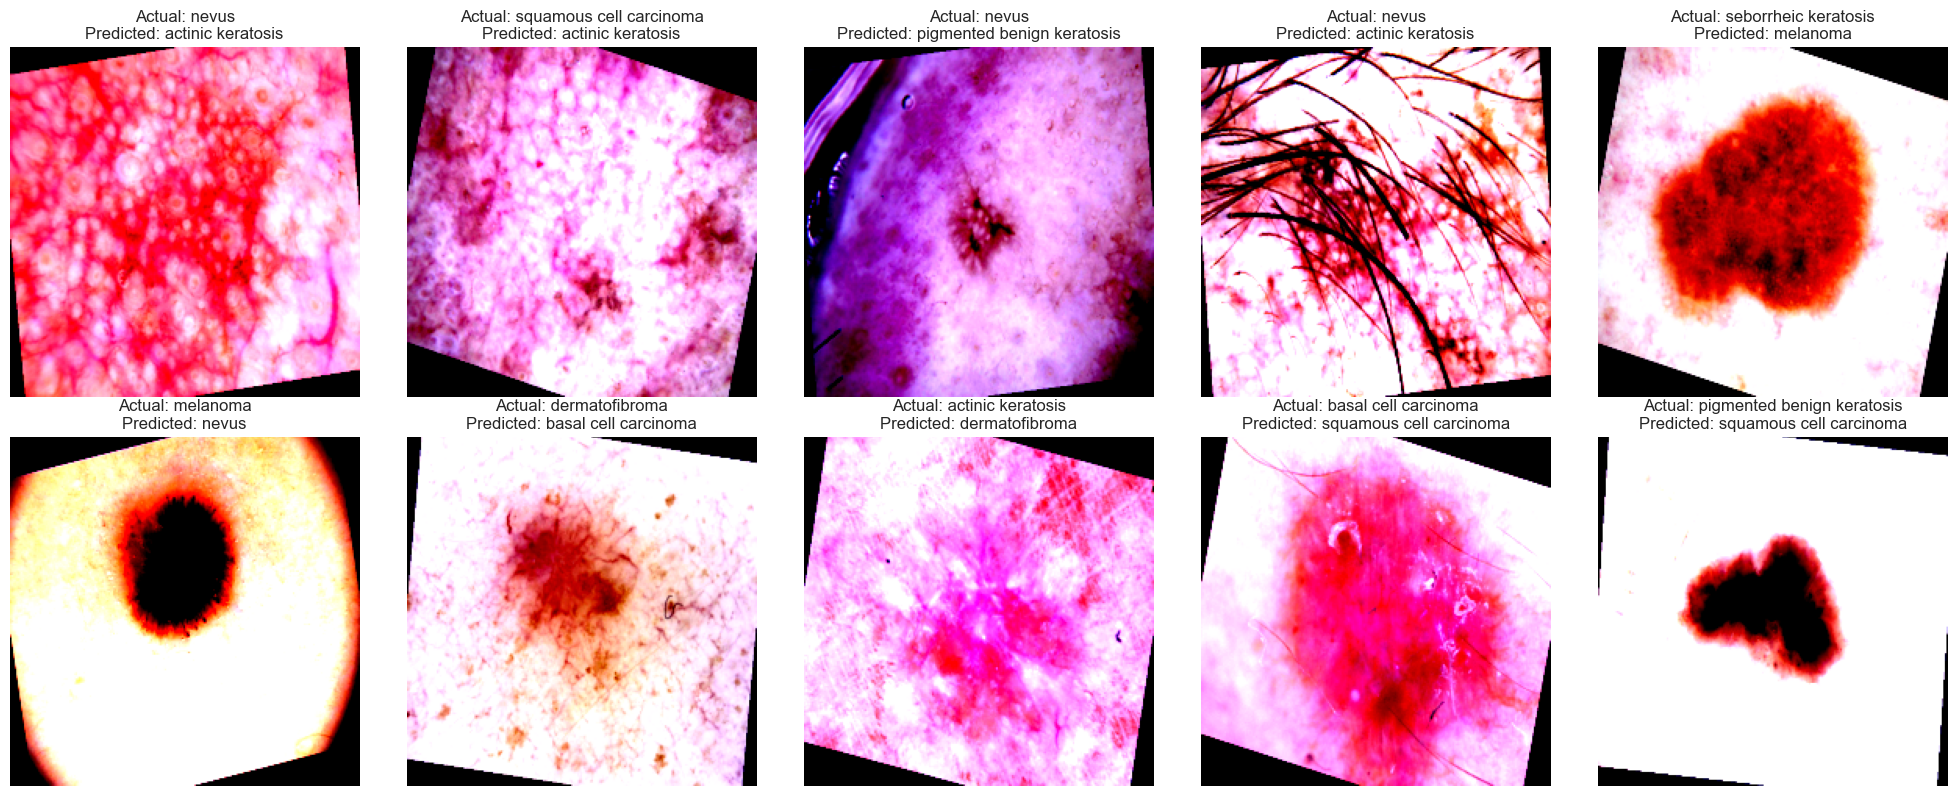

In [36]:
show_misclassified_images(model, val_loader, device, train_dataset.classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

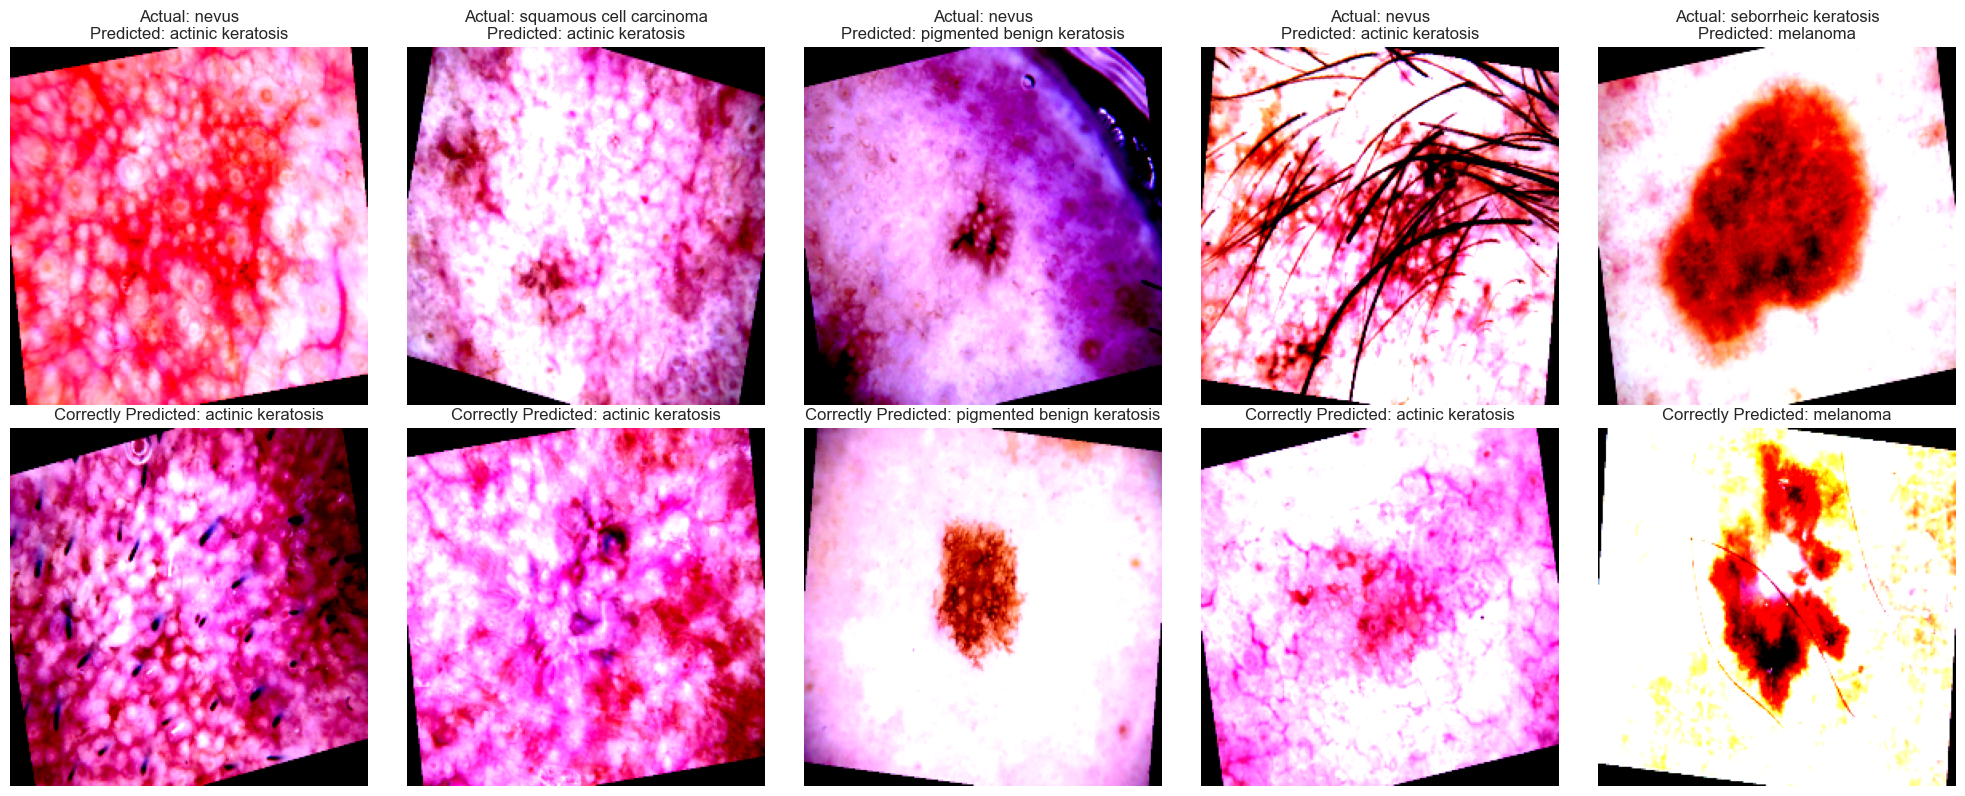

In [38]:
# show misclassified images along with one image from predicted class
import matplotlib.pyplot as plt

def show_misclassified_images_with_predicted(model, data_loader, device, class_names):
    model.eval()  # Set the model to evaluation mode
    misclassified_images = []
    correct_labels = []
    predicted_labels = []
    correct_images = {class_name: [] for class_name in class_names}

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Get misclassified images
            misclassified_idx = (predicted != labels).nonzero(as_tuple=True)[0]
            misclassified_images.extend(images[misclassified_idx])
            correct_labels.extend(labels[misclassified_idx].cpu().numpy())
            predicted_labels.extend(predicted[misclassified_idx].cpu().numpy())

            # Get correctly classified images
            correct_idx = (predicted == labels).nonzero(as_tuple=True)[0]
            for idx in correct_idx:
                correct_images[class_names[labels[idx].item()]].append(images[idx])

    # Display misclassified images with original and predicted labels
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i, (image, correct, predicted) in enumerate(zip(misclassified_images[:5], correct_labels[:5], predicted_labels[:10])):
        image = image.permute(1, 2, 0).cpu().numpy()  # Ensure the tensor has 3 dimensions
        axes[0, i].imshow(image)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Actual: {class_names[correct]}\nPredicted: {class_names[predicted]}")

        # Find one correctly classified image from the predicted class
        if correct_images[class_names[predicted]]:
            correct_image = correct_images[class_names[predicted]].pop(0)
            correct_image = correct_image.permute(1, 2, 0).cpu().numpy()
            axes[1, i].imshow(correct_image)
            axes[1, i].axis('off')
            axes[1, i].set_title(f"Correctly Predicted: {class_names[predicted]}")

    plt.tight_layout()
    plt.show()

# Call the function
show_misclassified_images_with_predicted(model, val_loader, device, train_dataset.classes)